In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/pan20-authorship-verification-training-small.zip -d /content/dataset


!pip install spacy --quiet
!python -m spacy download en_core_web_sm --quiet

Mounted at /content/drive
Archive:  /content/drive/MyDrive/pan20-authorship-verification-training-small.zip
   creating: /content/dataset/pan20-authorship-verification-training-small/
  inflating: /content/dataset/pan20-authorship-verification-training-small/pan20-authorship-verification-training-small-truth.jsonl  
  inflating: /content/dataset/pan20-authorship-verification-training-small/pan20-authorship-verification-training-small.jsonl  
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 143.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import os
import json

base_path = "/content/dataset"
print("Directory contents:")
for root, dirs, files in os.walk(base_path):
    level = root.replace(base_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    if level < 2:
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:
            print(f'{subindent}{file}')
        if len(files) > 5:
            print(f'{subindent}... and {len(files)-5} more files')

Directory contents:
dataset/
  pan20-authorship-verification-training-small/
    pan20-authorship-verification-training-small.jsonl
    pan20-authorship-verification-training-small-truth.jsonl


In [ ]:
import json

base_path = "/content/dataset/pan20-authorship-verification-training-small"

data_file = f"{base_path}/pan20-authorship-verification-training-small.jsonl"
with open(data_file, 'r') as f:
    data = [json.loads(line) for line in f]

print(f"Total samples: {len(data)}")
print(f"Keys in each entry: {data[0].keys()}")
print("\nSample entry:")
print(json.dumps(data[0], indent=2)[:1000])

Total samples: 52601
Keys in each entry: dict_keys(['id', 'fandoms', 'pair'])

Sample entry:
{
  "id": "6cced668-6e51-5212-873c-717f2bc91ce6",
  "fandoms": [
    "Guardians of Ga'Hoole",
    "Hetalia - Axis Powers"
  ],
  "pair": [
    "I shift a bit, warily letting my eyes dart from one owl to the other -- but my eyes are trained on the Barn Owl the most. Like Hoole...so like Hoole... He turns a bit, and our eyes meet directly. I can\"t describe it...in this next moment, I don\"t look away, how awkward it seems. I stare into his eyes. They\"re like Hoole\"s... They are Barn Owl eyes, but Hoole\"s eyes. They\"re his eyes...Hoole\"s eyes... They hold that light of valor, justice, that one glow that I always made me feel my gizzard twitch in the bottom of my heart. Hoole... He never wanted me, did he? He loved me, but only who I was pretending to be. He never loved me, only Emerilla...lucky owl. I just wanted to belong -- because I was nothing -- and he gave me that. He was so fair, so k

In [ ]:
truth_file = f"{base_path}/pan20-authorship-verification-training-small-truth.jsonl"
with open(truth_file, 'r') as f:
    truth = [json.loads(line) for line in f]

print(f"Total labels: {len(truth)}")
print(f"Keys: {truth[0].keys()}")
print(f"Sample entries:")
for t in truth[:5]:
    print(t)

Total labels: 52601
Keys: dict_keys(['id', 'same', 'authors'])
Sample entries:
{'id': '6cced668-6e51-5212-873c-717f2bc91ce6', 'same': True, 'authors': ['1446633', '1446633']}
{'id': '3c6c188a-db28-59aa-8c09-3d0f799ff579', 'same': True, 'authors': ['1446633', '1446633']}
{'id': 'b0cfa94f-c9ec-5aa5-8331-a5a249b664cf', 'same': True, 'authors': ['1446633', '1446633']}
{'id': 'e6e86e73-9a7b-58f2-a652-a17b4a1bcabf', 'same': True, 'authors': ['1446633', '1446633']}
{'id': '4fe541af-912e-5a86-81a5-94c6d3891509', 'same': True, 'authors': ['1446633', '1446633']}


In [ ]:
truth_dict = {t['id']: t for t in truth}

sample = data[0]
sample_id = sample['id']
label = truth_dict.get(sample_id)

print(f"ID: {sample_id}")
print(f"Label: {label}")
print(f"\nText fields available: {[k for k in sample.keys() if k != 'id']}")

ID: 6cced668-6e51-5212-873c-717f2bc91ce6
Label: {'id': '6cced668-6e51-5212-873c-717f2bc91ce6', 'same': True, 'authors': ['1446633', '1446633']}

Text fields available: ['fandoms', 'pair']


In [ ]:
import os
import json
import pickle
import torch
import re
import numpy as np
import sys
import datetime
import logging
import gc
import psutil
import warnings
from typing import List, Dict, Generator, Optional, Tuple
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer
from scipy.sparse import vstack, save_npz, load_npz

os.environ["TOKENIZERS_PARALLELISM"] = "false"

from transformers import (
    BertTokenizerFast,
    DistilBertTokenizerFast,
    RobertaTokenizerFast
)
from transformers import logging as transformers_logging
transformers_logging.set_verbosity_error()

warnings.filterwarnings('ignore')

DATASET_SIZE = 'small'
DATASET_TAG = f'pan20_{DATASET_SIZE}'

PREPROCESS_MODELS = {
    'distilbert': True,
    'bert': True,
    'roberta': True
}

MODEL_CONFIGS = {
    'distilbert': {
        'name': 'distilbert-base-uncased',
        'tokenizer_class': DistilBertTokenizerFast,
        'max_len': 512,
    },
    'bert': {
        'name': 'bert-base-uncased',
        'tokenizer_class': BertTokenizerFast,
        'max_len': 512,
    },
    'roberta': {
        'name': 'roberta-base',
        'tokenizer_class': RobertaTokenizerFast,
        'max_len': 512,
    }
}

NGRAM_RANGE = (3, 4)
MAX_FEATURES = 30000

MEMORY_MODE = 'high'

MEMORY_PRESETS = {
    'low': {
        'tensor_batch_size': 3000,
        'char_chunk_size': 3000,
        'tokenizer_batch_size': 5000,
        'num_workers': 0,
    },
    'medium': {
        'tensor_batch_size': 15000,
        'char_chunk_size': 20000,
        'tokenizer_batch_size': 10000,
        'num_workers': 2,
    },
    'high': {
        'tensor_batch_size': 30000,
        'char_chunk_size': 50000,
        'tokenizer_batch_size': 20000,
        'num_workers': 4,
    },
    'ultra': {
        'tensor_batch_size': 100000,
        'char_chunk_size': 100000,
        'tokenizer_batch_size': 50000,
        'num_workers': 4,
    }
}

_config = MEMORY_PRESETS[MEMORY_MODE]
TENSOR_BATCH_SIZE = _config['tensor_batch_size']
CHAR_CHUNK_SIZE = _config['char_chunk_size']
TOKENIZER_BATCH_SIZE = _config['tokenizer_batch_size']
NUM_WORKERS = _config['num_workers']

BASE_DIR = '/content/drive/MyDrive/Final_PAN20_Authorship/processed_states'
DATA_SOURCE_DIR_SMALL = '/content/dataset/pan20-authorship-verification-training-small'
DATA_SOURCE_DIR_LARGE = '/content/dataset/pan20-authorship-verification-training-large'
TEMP_DIR = '/content/temp_tensors'

os.makedirs(BASE_DIR, exist_ok=True)
os.makedirs(TEMP_DIR, exist_ok=True)

def get_data_source_dir():
    return DATA_SOURCE_DIR_LARGE if DATASET_SIZE == 'large' else DATA_SOURCE_DIR_SMALL

def get_file_paths(base_dir: str, dataset: str, model_type: str, model_name: str, max_len: int) -> Dict[str, str]:
    safe_model_name = model_name.replace('/', '-')
    slug = f"{dataset}_{safe_model_name}_len{max_len}"

    return {
        'tensors': os.path.join(base_dir, f"{slug}_tensors.pt"),
        'labels': os.path.join(base_dir, f"{dataset}_labels.pt"),
    }

def get_ngram_paths(base_dir: str, dataset: str) -> Dict[str, str]:
    n_min, n_max = NGRAM_RANGE
    slug = f"{dataset}_char_ngram_n{n_min}-{n_max}_feat{MAX_FEATURES}"

    return {
        'model': os.path.join(base_dir, f"{slug}_model.pkl"),
        'matrix': os.path.join(base_dir, f"{slug}_matrix.npz"),
    }

class FlushingLogger:
    def __init__(self, logger):
        self.logger = logger

    def info(self, msg):
        self.logger.info(msg)
        for h in self.logger.handlers: h.flush()

    def error(self, msg):
        self.logger.error(msg)
        for h in self.logger.handlers: h.flush()

    def warning(self, msg):
        self.logger.warning(msg)
        for h in self.logger.handlers: h.flush()

def setup_logging(log_dir='/content/drive/MyDrive/Final_PAN20_Authorship'):
    os.makedirs(log_dir, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    log_file = os.path.join(log_dir, f'preprocessing_log_{timestamp}.txt')

    base_logger = logging.getLogger('preprocessing')
    base_logger.setLevel(logging.INFO)
    base_logger.handlers = []

    file_handler = logging.FileHandler(log_file)
    console_handler = logging.StreamHandler(sys.stdout)
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    file_handler.setFormatter(formatter)
    console_handler.setFormatter(formatter)

    base_logger.addHandler(file_handler)
    base_logger.addHandler(console_handler)
    return FlushingLogger(base_logger)

logger = setup_logging()

def log_memory_usage(stage=""):
    process = psutil.Process(os.getpid())
    mem_gb = process.memory_info().rss / 1e9
    logger.info(f"[MEM {stage}] RAM: {mem_gb:.2f}GB")
    if mem_gb > 10:
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

class OptimizedCharacterNGramBaseline:
    def __init__(self, ngram_range=(3, 4), max_features=30000):
        self.ngram_range = ngram_range
        self.max_features = max_features
        self.hasher = HashingVectorizer(
            analyzer='char',
            ngram_range=ngram_range,
            n_features=max_features,
            lowercase=True,
            norm=None,
            alternate_sign=False
        )
        self.tfidf_transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True)
        self.hashed_matrix = None

    def _clean_text(self, text: str, max_len: int = 5000) -> str:
        clean_pattern = re.compile(r'[\x00-\x08\x0b-\x0c\x0e-\x1f\x7f]')
        space_pattern = re.compile(r'\s+')
        if len(text) > max_len:
            text = text[:max_len//2] + ' ' + text[-max_len//2:]
        return space_pattern.sub(' ', clean_pattern.sub('', text)).strip()

    def fit_streaming(self, text_generator: Generator, total_count: int,
                      temp_dir: str, chunk_size: int = 3000):
        logger.info(f"[CharNGram] Streaming fit on {total_count} texts")

        chunk_files = []
        current_chunk = []
        chunk_idx = 0

        with tqdm(total=total_count, desc="Hashing texts", unit="doc") as pbar:
            for text in text_generator:
                current_chunk.append(self._clean_text(text))

                if len(current_chunk) >= chunk_size:
                    hashed = self.hasher.transform(current_chunk)
                    chunk_path = os.path.join(temp_dir, f"char_chunk_{chunk_idx}.npz")
                    save_npz(chunk_path, hashed)
                    chunk_files.append(chunk_path)

                    pbar.update(len(current_chunk))
                    chunk_idx += 1
                    del hashed, current_chunk
                    current_chunk = []
                    gc.collect()

        if current_chunk:
            hashed = self.hasher.transform(current_chunk)
            chunk_path = os.path.join(temp_dir, f"char_chunk_{chunk_idx}.npz")
            save_npz(chunk_path, hashed)
            chunk_files.append(chunk_path)
            pbar.update(len(current_chunk))
            del hashed, current_chunk
            gc.collect()

        logger.info(f"[CharNGram] Combining {len(chunk_files)} chunks...")
        combined = None
        for i, chunk_path in enumerate(tqdm(chunk_files, desc="Combining")):
            chunk_matrix = load_npz(chunk_path)
            combined = chunk_matrix if combined is None else vstack([combined, chunk_matrix])
            os.remove(chunk_path)
            if i % 10 == 0:
                gc.collect()

        self.hashed_matrix = combined
        self.tfidf_transformer.fit(self.hashed_matrix)
        logger.info("[CharNGram] Fit Complete")

class UniversalPreprocessor:
    def __init__(self, model_type: str):
        config = MODEL_CONFIGS[model_type]
        self.model_type = model_type
        self.model_name = config['name']
        self.max_length = config['max_len']

        logger.info(f"[{model_type.upper()}] Initializing tokenizer: {self.model_name}")
        self.tokenizer = config['tokenizer_class'].from_pretrained(self.model_name)
        self.clean_regex = re.compile(r'\s+')

    def clean_text(self, text: str) -> str:
        text = self.clean_regex.sub(' ', text).strip()
        if len(text) > 3000:
            return text[:1500] + ' ... ' + text[-1500:]
        return text

    def tokenize_pair(self, text1: str, text2: str) -> Dict[str, torch.Tensor]:
        return self.tokenizer(
            self.clean_text(text1),
            self.clean_text(text2),
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt',
            return_token_type_ids=True
        )

    def tokenize_dataset_streaming(
        self,
        pairs_data: List[Dict],
        documents: Dict,
        temp_dir: str,
        batch_size: int = 3000
    ) -> List[str]:
        logger.info(f"[{self.model_type.upper()}] Tokenizing {len(pairs_data)} pairs")

        batch_files = []
        total = len(pairs_data)
        is_direct_text = 'text1' in documents

        for i in range(0, total, batch_size):
            batch_pairs = pairs_data[i:i + batch_size]

            batch_text_a = []
            batch_text_b = []

            for item in batch_pairs:
                if is_direct_text:
                    t1 = documents['text1'].get(item['id'], "")
                    t2 = documents['text2'].get(item['id'], "")
                else:
                    id1, id2 = item['pair']
                    t1 = documents.get(id1, "")
                    t2 = documents.get(id2, "")

                batch_text_a.append(self.clean_text(t1))
                batch_text_b.append(self.clean_text(t2))

            encodings = self.tokenizer(
                batch_text_a,
                batch_text_b,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors='pt',
                return_token_type_ids=True
            )

            batch_path = os.path.join(temp_dir, f"{self.model_type}_batch_{i//batch_size}.pt")
            torch.save({
                'input_ids': encodings['input_ids'],
                'attention_mask': encodings['attention_mask'],
                'token_type_ids': encodings.get('token_type_ids',
                                                 torch.zeros_like(encodings['input_ids']))
            }, batch_path)
            batch_files.append(batch_path)

            del batch_text_a, batch_text_b, encodings
            gc.collect()

            if (i // batch_size) % 5 == 0:
                log_memory_usage(f"After {self.model_type} batch {i//batch_size}")

        return batch_files

    def concatenate_batches(self, batch_files: List[str], output_path: str):
        logger.info(f"[{self.model_type.upper()}] Concatenating {len(batch_files)} batches")

        all_input_ids = []
        all_attention_masks = []
        all_token_type_ids = []

        for batch_path in tqdm(batch_files, desc="Loading batches"):
            batch_data = torch.load(batch_path, weights_only=False)
            all_input_ids.append(batch_data['input_ids'])
            all_attention_masks.append(batch_data['attention_mask'])
            all_token_type_ids.append(batch_data['token_type_ids'])
            os.remove(batch_path)
            del batch_data

        final_dict = {
            'input_ids': torch.cat(all_input_ids, dim=0),
            'attention_mask': torch.cat(all_attention_masks, dim=0),
            'token_type_ids': torch.cat(all_token_type_ids, dim=0)
        }

        torch.save(final_dict, output_path)
        logger.info(f"[{self.model_type.upper()}] Saved to: {output_path}")

        del all_input_ids, all_attention_masks, all_token_type_ids, final_dict
        gc.collect()

    def tokenize_dataset_fast(
        self,
        pairs_data: List[Dict],
        documents: Dict,
        output_path: str
    ) -> None:
        logger.info(f"[{self.model_type.upper()}-FAST] Tokenizing {len(pairs_data)} pairs in-memory")
        log_memory_usage("Before tokenization")

        total = len(pairs_data)
        is_direct_text = 'text1' in documents

        all_input_ids = []
        all_attention_masks = []
        all_token_type_ids = []

        batch_size = TOKENIZER_BATCH_SIZE

        for i in tqdm(range(0, total, batch_size), desc=f"Tokenizing {self.model_type}"):
            batch_pairs = pairs_data[i:i + batch_size]

            batch_text_a = []
            batch_text_b = []

            for item in batch_pairs:
                if is_direct_text:
                    t1 = documents['text1'].get(item['id'], "")
                    t2 = documents['text2'].get(item['id'], "")
                else:
                    id1, id2 = item['pair']
                    t1 = documents.get(id1, "")
                    t2 = documents.get(id2, "")

                batch_text_a.append(self.clean_text(t1))
                batch_text_b.append(self.clean_text(t2))

            encodings = self.tokenizer(
                batch_text_a,
                batch_text_b,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors='pt',
                return_token_type_ids=True
            )

            all_input_ids.append(encodings['input_ids'])
            all_attention_masks.append(encodings['attention_mask'])
            all_token_type_ids.append(encodings.get('token_type_ids',
                                                     torch.zeros_like(encodings['input_ids'])))

            del batch_text_a, batch_text_b, encodings

        log_memory_usage("After tokenization, before concat")

        logger.info(f"[{self.model_type.upper()}-FAST] Concatenating {len(all_input_ids)} batches...")
        final_dict = {
            'input_ids': torch.cat(all_input_ids, dim=0),
            'attention_mask': torch.cat(all_attention_masks, dim=0),
            'token_type_ids': torch.cat(all_token_type_ids, dim=0)
        }

        del all_input_ids, all_attention_masks, all_token_type_ids
        gc.collect()

        torch.save(final_dict, output_path)
        logger.info(f"[{self.model_type.upper()}-FAST] ✓ Saved to: {output_path}")

        log_memory_usage("After save")

class SiamesePreprocessor:
    def __init__(self, model_type: str = 'bert'):
        config = MODEL_CONFIGS[model_type]
        self.model_type = model_type
        self.model_name = config['name']
        self.max_length = config['max_len']

        logger.info(f"[SIAMESE-{model_type.upper()}] Initializing tokenizer")
        self.tokenizer = config['tokenizer_class'].from_pretrained(self.model_name)
        self.clean_regex = re.compile(r'\s+')

    def clean_text(self, text: str) -> str:
        text = self.clean_regex.sub(' ', text).strip()
        if len(text) > 3000:
            return text[:1500] + ' ... ' + text[-1500:]
        return text

    def tokenize_dataset_streaming(
        self,
        pairs_data: List[Dict],
        documents: Dict,
        temp_dir: str,
        batch_size: int = 3000
    ) -> List[str]:
        logger.info(f"[SIAMESE] Tokenizing {len(pairs_data)} pairs separately")

        batch_files = []
        total = len(pairs_data)
        is_direct_text = 'text1' in documents

        for i in range(0, total, batch_size):
            batch_pairs = pairs_data[i:i + batch_size]

            batch_text_a = []
            batch_text_b = []

            for item in batch_pairs:
                if is_direct_text:
                    t1 = documents['text1'].get(item['id'], "")
                    t2 = documents['text2'].get(item['id'], "")
                else:
                    id1, id2 = item['pair']
                    t1 = documents.get(id1, "")
                    t2 = documents.get(id2, "")

                batch_text_a.append(self.clean_text(t1))
                batch_text_b.append(self.clean_text(t2))

            enc_a = self.tokenizer(
                batch_text_a,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors='pt'
            )

            enc_b = self.tokenizer(
                batch_text_b,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors='pt'
            )

            batch_path = os.path.join(temp_dir, f"siamese_{self.model_type}_batch_{i//batch_size}.pt")
            torch.save({
                'input_ids_a': enc_a['input_ids'],
                'attention_mask_a': enc_a['attention_mask'],
                'input_ids_b': enc_b['input_ids'],
                'attention_mask_b': enc_b['attention_mask'],
            }, batch_path)
            batch_files.append(batch_path)

            del batch_text_a, batch_text_b, enc_a, enc_b
            gc.collect()

        return batch_files

    def concatenate_batches(self, batch_files: List[str], output_path: str):
        logger.info(f"[SIAMESE] Concatenating {len(batch_files)} batches")

        all_ids_a, all_mask_a = [], []
        all_ids_b, all_mask_b = [], []

        for batch_path in tqdm(batch_files, desc="Loading"):
            batch = torch.load(batch_path, weights_only=False)
            all_ids_a.append(batch['input_ids_a'])
            all_mask_a.append(batch['attention_mask_a'])
            all_ids_b.append(batch['input_ids_b'])
            all_mask_b.append(batch['attention_mask_b'])
            os.remove(batch_path)
            del batch

        final_dict = {
            'input_ids_a': torch.cat(all_ids_a, dim=0),
            'attention_mask_a': torch.cat(all_mask_a, dim=0),
            'input_ids_b': torch.cat(all_ids_b, dim=0),
            'attention_mask_b': torch.cat(all_mask_b, dim=0),
        }

        torch.save(final_dict, output_path)
        logger.info(f"[SIAMESE] Saved to: {output_path}")

        del all_ids_a, all_mask_a, all_ids_b, all_mask_b, final_dict
        gc.collect()

    def tokenize_dataset_fast(
        self,
        pairs_data: List[Dict],
        documents: Dict,
        output_path: str
    ) -> None:
        logger.info(f"[SIAMESE-FAST] Tokenizing {len(pairs_data)} pairs in-memory")
        log_memory_usage("Before Siamese tokenization")

        total = len(pairs_data)
        is_direct_text = 'text1' in documents

        all_ids_a, all_mask_a = [], []
        all_ids_b, all_mask_b = [], []

        batch_size = TOKENIZER_BATCH_SIZE

        for i in tqdm(range(0, total, batch_size), desc="Tokenizing Siamese"):
            batch_pairs = pairs_data[i:i + batch_size]

            batch_text_a = []
            batch_text_b = []

            for item in batch_pairs:
                if is_direct_text:
                    t1 = documents['text1'].get(item['id'], "")
                    t2 = documents['text2'].get(item['id'], "")
                else:
                    id1, id2 = item['pair']
                    t1 = documents.get(id1, "")
                    t2 = documents.get(id2, "")

                batch_text_a.append(self.clean_text(t1))
                batch_text_b.append(self.clean_text(t2))

            enc_a = self.tokenizer(
                batch_text_a,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors='pt'
            )

            enc_b = self.tokenizer(
                batch_text_b,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors='pt'
            )

            all_ids_a.append(enc_a['input_ids'])
            all_mask_a.append(enc_a['attention_mask'])
            all_ids_b.append(enc_b['input_ids'])
            all_mask_b.append(enc_b['attention_mask'])

            del batch_text_a, batch_text_b, enc_a, enc_b

        log_memory_usage("After Siamese tokenization, before concat")

        logger.info("[SIAMESE-FAST] Concatenating...")
        final_dict = {
            'input_ids_a': torch.cat(all_ids_a, dim=0),
            'attention_mask_a': torch.cat(all_mask_a, dim=0),
            'input_ids_b': torch.cat(all_ids_b, dim=0),
            'attention_mask_b': torch.cat(all_mask_b, dim=0),
        }

        del all_ids_a, all_mask_a, all_ids_b, all_mask_b
        gc.collect()

        torch.save(final_dict, output_path)
        logger.info(f"[SIAMESE-FAST] ✓ Saved to: {output_path}")
        log_memory_usage("After save")

def load_pairs_and_truth(data_path: str) -> Tuple[List[Dict], Dict, str]:
    logger.info(f"[DATA] Loading from: {data_path}")

    possible_names = [
        'pan20-authorship-verification-training-small.jsonl',
        'pan20-authorship-verification-training-large.jsonl',
        'pairs.jsonl'
    ]

    pairs_file = None
    for name in possible_names:
        path = os.path.join(data_path, name)
        if os.path.exists(path):
            pairs_file = path
            break

    if pairs_file is None:
        raise FileNotFoundError(f"No pairs file found in {data_path}")

    pairs_data = []
    with open(pairs_file, 'r') as f:
        for line in f:
            pairs_data.append(json.loads(line))

    logger.info(f"[DATA] Loaded {len(pairs_data)} pairs")

    truth_map = {}
    truth_candidates = [
        pairs_file.replace('.jsonl', '-truth.jsonl'),
        os.path.join(data_path, 'truth.jsonl')
    ]

    for truth_file in truth_candidates:
        if os.path.exists(truth_file):
            with open(truth_file, 'r') as f:
                for line in f:
                    x = json.loads(line)
                    truth_map[x['id']] = x['same']
            break

    logger.info(f"[DATA] Loaded {len(truth_map)} truth labels")

    return pairs_data, truth_map, pairs_file


def text_generator(pairs_data: List[Dict], data_path: str) -> Generator[str, None, None]:
    if len(pairs_data[0]['pair'][0]) > 50 and not pairs_data[0]['pair'][0].endswith('.txt'):
        for p in pairs_data:
            yield p['pair'][0]
            yield p['pair'][1]
    else:
        seen = set()
        for p in pairs_data:
            for doc_id in p['pair']:
                if doc_id not in seen:
                    seen.add(doc_id)
                    fpath = os.path.join(data_path, doc_id)
                    if os.path.exists(fpath):
                        with open(fpath, 'r', encoding='utf-8') as f:
                            yield f.read()
                    else:
                        yield ""


def load_documents_dict(pairs_data: List[Dict], data_path: str) -> Dict:
    logger.info("[DATA] Loading documents...")

    if len(pairs_data[0]['pair'][0]) > 50 and not pairs_data[0]['pair'][0].endswith('.txt'):
        text1_d, text2_d = {}, {}
        for p in pairs_data:
            text1_d[p['id']] = p['pair'][0]
            text2_d[p['id']] = p['pair'][1]
        return {'text1': text1_d, 'text2': text2_d}
    else:
        text_cache = {}
        unique_files = set()
        for p in pairs_data:
            unique_files.add(p['pair'][0])
            unique_files.add(p['pair'][1])

        missing = 0
        for doc_id in tqdm(unique_files, desc="Reading files"):
            fpath = os.path.join(data_path, doc_id)
            if os.path.exists(fpath):
                with open(fpath, 'r', encoding='utf-8') as f:
                    text_cache[doc_id] = f.read()
            else:
                missing += 1
                text_cache[doc_id] = ""

        if missing > 0:
            logger.warning(f"⚠️ {missing} files not found")

        return text_cache

def run_preprocessing_pipeline(force_rerun: bool = False, include_siamese: bool = True):
    data_path = get_data_source_dir()

    logger.info("=" * 60)
    logger.info(f"PREPROCESSING PIPELINE - Dataset: {DATASET_TAG}")
    logger.info("=" * 60)
    logger.info(f"Memory Mode: {MEMORY_MODE}")
    logger.info(f"  Tensor Batch Size: {TENSOR_BATCH_SIZE:,}")
    logger.info(f"  Char Chunk Size: {CHAR_CHUNK_SIZE:,}")
    logger.info(f"  Tokenizer Batch Size: {TOKENIZER_BATCH_SIZE:,}")
    logger.info(f"  Fast Mode: {'YES' if MEMORY_MODE in ['high', 'ultra'] else 'NO (streaming)'}")
    log_memory_usage("Start")

    pairs_data, truth_map, _ = load_pairs_and_truth(data_path)

    labels_path = os.path.join(BASE_DIR, f"{DATASET_TAG}_labels.pt")
    if not os.path.exists(labels_path) or force_rerun:
        if truth_map:
            labels = torch.tensor([1 if truth_map.get(p['id'], False) else 0 for p in pairs_data])
            torch.save(labels, labels_path)
            logger.info(f"✓ Labels saved to: {labels_path}")
        else:
            logger.warning("No truth labels found!")

    ngram_paths = get_ngram_paths(BASE_DIR, DATASET_TAG)
    if not os.path.exists(ngram_paths['model']) or force_rerun:
        logger.info("\n=== Processing Character N-Grams ===")

        char_model = OptimizedCharacterNGramBaseline(
            ngram_range=NGRAM_RANGE,
            max_features=MAX_FEATURES
        )

        is_inline = len(pairs_data[0]['pair'][0]) > 50 and not pairs_data[0]['pair'][0].endswith('.txt')
        if is_inline:
            total_texts = len(pairs_data) * 2
        else:
            unique = set()
            for p in pairs_data:
                unique.add(p['pair'][0])
                unique.add(p['pair'][1])
            total_texts = len(unique)

        char_model.fit_streaming(
            text_generator(pairs_data, data_path),
            total_count=total_texts,
            temp_dir=TEMP_DIR,
            chunk_size=CHAR_CHUNK_SIZE
        )

        save_npz(ngram_paths['matrix'], char_model.hashed_matrix)
        char_model.hashed_matrix = None

        with open(ngram_paths['model'], 'wb') as f:
            pickle.dump(char_model, f, protocol=pickle.HIGHEST_PROTOCOL)

        logger.info(f"✓ Char model saved to: {ngram_paths['model']}")
        del char_model
        gc.collect()
    else:
        logger.info("✓ Char n-gram model already exists")

    log_memory_usage("After char n-grams")

    documents = load_documents_dict(pairs_data, data_path)
    log_memory_usage("After loading docs")

    for model_type, should_process in PREPROCESS_MODELS.items():
        if not should_process:
            continue

        config = MODEL_CONFIGS[model_type]
        paths = get_file_paths(
            BASE_DIR, DATASET_TAG, model_type,
            config['name'], config['max_len']
        )

        if os.path.exists(paths['tensors']) and not force_rerun:
            logger.info(f"✓ {model_type.upper()} tensors already exist")
            continue

        logger.info(f"\n=== Processing {model_type.upper()} ===")

        preprocessor = UniversalPreprocessor(model_type)

        if MEMORY_MODE in ['high', 'ultra']:
            preprocessor.tokenize_dataset_fast(pairs_data, documents, paths['tensors'])
        else:
            batch_files = preprocessor.tokenize_dataset_streaming(
                pairs_data, documents, TEMP_DIR, TENSOR_BATCH_SIZE
            )
            preprocessor.concatenate_batches(batch_files, paths['tensors'])

        del preprocessor
        gc.collect()
        log_memory_usage(f"After {model_type}")

    if include_siamese:
        siamese_path = os.path.join(BASE_DIR, f"{DATASET_TAG}_bert-base-uncased_siamese.pt")

        if not os.path.exists(siamese_path) or force_rerun:
            logger.info("\n=== Processing Siamese Format (BERT) ===")

            siamese_prep = SiamesePreprocessor('bert')

            if MEMORY_MODE in ['high', 'ultra']:
                siamese_prep.tokenize_dataset_fast(pairs_data, documents, siamese_path)
            else:
                batch_files = siamese_prep.tokenize_dataset_streaming(
                    pairs_data, documents, TEMP_DIR, TENSOR_BATCH_SIZE
                )
                siamese_prep.concatenate_batches(batch_files, siamese_path)

            del siamese_prep
            gc.collect()
        else:
            logger.info("✓ Siamese tensors already exist")

    del documents
    gc.collect()

    import shutil
    if os.path.exists(TEMP_DIR):
        shutil.rmtree(TEMP_DIR)

    log_memory_usage("Final")
    logger.info("\n" + "=" * 60)
    logger.info("✅ PREPROCESSING COMPLETE")
    logger.info("=" * 60)

    logger.info("\nGenerated Files:")
    logger.info(f"  Labels: {labels_path}")
    logger.info(f"  Char N-gram: {ngram_paths['model']}")
    for model_type in PREPROCESS_MODELS:
        if PREPROCESS_MODELS[model_type]:
            config = MODEL_CONFIGS[model_type]
            paths = get_file_paths(BASE_DIR, DATASET_TAG, model_type,
                                   config['name'], config['max_len'])
            logger.info(f"  {model_type.upper()}: {paths['tensors']}")
    if include_siamese:
        logger.info(f"  Siamese: {siamese_path}")


if __name__ == "__main__":
    run_preprocessing_pipeline(force_rerun=False, include_siamese=True)

2025-12-01 14:22:32,855 - INFO - ============================================================


INFO:preprocessing:============================================================


2025-12-01 14:22:32,858 - INFO - PREPROCESSING PIPELINE - Dataset: pan20_small


INFO:preprocessing:PREPROCESSING PIPELINE - Dataset: pan20_small


2025-12-01 14:22:32,859 - INFO - ============================================================


INFO:preprocessing:============================================================


2025-12-01 14:22:32,860 - INFO - Memory Mode: high


INFO:preprocessing:Memory Mode: high


2025-12-01 14:22:32,862 - INFO -   Tensor Batch Size: 30,000


INFO:preprocessing:  Tensor Batch Size: 30,000


2025-12-01 14:22:32,863 - INFO -   Char Chunk Size: 50,000


INFO:preprocessing:  Char Chunk Size: 50,000


2025-12-01 14:22:32,865 - INFO -   Tokenizer Batch Size: 20,000


INFO:preprocessing:  Tokenizer Batch Size: 20,000


2025-12-01 14:22:32,866 - INFO -   Fast Mode: YES


INFO:preprocessing:  Fast Mode: YES


2025-12-01 14:22:32,868 - INFO - [MEM Start] RAM: 0.70GB


INFO:preprocessing:[MEM Start] RAM: 0.70GB


2025-12-01 14:22:32,869 - INFO - [DATA] Loading from: /content/dataset/pan20-authorship-verification-training-small


INFO:preprocessing:[DATA] Loading from: /content/dataset/pan20-authorship-verification-training-small


2025-12-01 14:22:43,329 - INFO - [DATA] Loaded 52601 pairs


INFO:preprocessing:[DATA] Loaded 52601 pairs


2025-12-01 14:22:43,455 - INFO - [DATA] Loaded 52590 truth labels


INFO:preprocessing:[DATA] Loaded 52590 truth labels


2025-12-01 14:22:43,908 - INFO - ✓ Char n-gram model already exists


INFO:preprocessing:✓ Char n-gram model already exists


2025-12-01 14:22:43,910 - INFO - [MEM After char n-grams] RAM: 3.12GB


INFO:preprocessing:[MEM After char n-grams] RAM: 3.12GB


2025-12-01 14:22:43,912 - INFO - [DATA] Loading documents...


INFO:preprocessing:[DATA] Loading documents...


2025-12-01 14:22:43,964 - INFO - [MEM After loading docs] RAM: 3.12GB


INFO:preprocessing:[MEM After loading docs] RAM: 3.12GB


2025-12-01 14:22:43,966 - INFO - ✓ DISTILBERT tensors already exist


INFO:preprocessing:✓ DISTILBERT tensors already exist


2025-12-01 14:22:43,968 - INFO - ✓ BERT tensors already exist


INFO:preprocessing:✓ BERT tensors already exist


2025-12-01 14:22:43,970 - INFO - ✓ ROBERTA tensors already exist


INFO:preprocessing:✓ ROBERTA tensors already exist


2025-12-01 14:22:43,971 - INFO - ✓ Siamese tensors already exist


INFO:preprocessing:✓ Siamese tensors already exist


2025-12-01 14:22:44,148 - INFO - [MEM Final] RAM: 3.12GB


INFO:preprocessing:[MEM Final] RAM: 3.12GB


2025-12-01 14:22:44,150 - INFO - 


INFO:preprocessing:


2025-12-01 14:22:44,151 - INFO - ✅ PREPROCESSING COMPLETE


INFO:preprocessing:✅ PREPROCESSING COMPLETE


2025-12-01 14:22:44,153 - INFO - ============================================================


INFO:preprocessing:============================================================


2025-12-01 14:22:44,154 - INFO - 
Generated Files:


INFO:preprocessing:
Generated Files:


2025-12-01 14:22:44,155 - INFO -   Labels: /content/drive/MyDrive/Final_PAN20_Authorship/processed_states/pan20_small_labels.pt


INFO:preprocessing:  Labels: /content/drive/MyDrive/Final_PAN20_Authorship/processed_states/pan20_small_labels.pt


2025-12-01 14:22:44,157 - INFO -   Char N-gram: /content/drive/MyDrive/Final_PAN20_Authorship/processed_states/pan20_small_char_ngram_n3-4_feat30000_model.pkl


INFO:preprocessing:  Char N-gram: /content/drive/MyDrive/Final_PAN20_Authorship/processed_states/pan20_small_char_ngram_n3-4_feat30000_model.pkl


2025-12-01 14:22:44,158 - INFO -   DISTILBERT: /content/drive/MyDrive/Final_PAN20_Authorship/processed_states/pan20_small_distilbert-base-uncased_len512_tensors.pt


INFO:preprocessing:  DISTILBERT: /content/drive/MyDrive/Final_PAN20_Authorship/processed_states/pan20_small_distilbert-base-uncased_len512_tensors.pt


2025-12-01 14:22:44,159 - INFO -   BERT: /content/drive/MyDrive/Final_PAN20_Authorship/processed_states/pan20_small_bert-base-uncased_len512_tensors.pt


INFO:preprocessing:  BERT: /content/drive/MyDrive/Final_PAN20_Authorship/processed_states/pan20_small_bert-base-uncased_len512_tensors.pt


2025-12-01 14:22:44,161 - INFO -   ROBERTA: /content/drive/MyDrive/Final_PAN20_Authorship/processed_states/pan20_small_roberta-base_len512_tensors.pt


INFO:preprocessing:  ROBERTA: /content/drive/MyDrive/Final_PAN20_Authorship/processed_states/pan20_small_roberta-base_len512_tensors.pt


2025-12-01 14:22:44,162 - INFO -   Siamese: /content/drive/MyDrive/Final_PAN20_Authorship/processed_states/pan20_small_bert-base-uncased_siamese.pt


INFO:preprocessing:  Siamese: /content/drive/MyDrive/Final_PAN20_Authorship/processed_states/pan20_small_bert-base-uncased_siamese.pt


In [ ]:
import os
import sys
import gc
import pickle
import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from typing import Dict, List, Optional, Tuple
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from transformers import (
    BertModel,
    BertTokenizerFast,
    DistilBertModel,
    DistilBertTokenizerFast,
    RobertaModel,
    RobertaTokenizerFast,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    EvalPrediction
)
from datasets import Dataset as HFDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score,
    precision_score, recall_score, confusion_matrix,
    classification_report
)
from sklearn.linear_model import LogisticRegression
import scipy.sparse
import warnings

from google.colab import drive
drive.mount('/content/drive')

warnings.filterwarnings('ignore')

LOAD_DIR = '/content/drive/MyDrive/Final_PAN20_Authorship/processed_states'
OUTPUT_DIR = '/content/drive/MyDrive/Final_PAN20_Authorship/authorship_results'
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATASET_TAG = 'pan20_small'

GPU_MEMORY_MODE = 'low'

GPU_PRESETS = {
    'low': {
        'batch_size': 32,
        'eval_batch_size': 64,
        'gradient_accumulation': 2,
        'max_length': 512,
    },
    'medium': {
        'batch_size': 64,
        'eval_batch_size': 128,
        'gradient_accumulation': 1,
        'max_length': 512,
    },
    'high': {
        'batch_size': 96,
        'eval_batch_size': 192,
        'gradient_accumulation': 1,
        'max_length': 512,
    },
    'ultra': {
        'batch_size': 128,
        'eval_batch_size': 256,
        'gradient_accumulation': 1,
        'max_length': 512,
    }
}

_gpu_config = GPU_PRESETS[GPU_MEMORY_MODE]
BATCH_SIZE = _gpu_config['batch_size']
EVAL_BATCH_SIZE = _gpu_config['eval_batch_size']
GRAD_ACCUMULATION = _gpu_config['gradient_accumulation']

LEARNING_RATE = 2e-5
EPOCHS = 5
SEED = 42
DROPOUT = 0.3

torch.manual_seed(SEED)
np.random.seed(SEED)

class Logger:
    def __init__(self, filename):
        self.terminal = sys.stdout
        self.log = open(filename, 'w')

    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)
        self.log.flush()

    def flush(self):
        self.terminal.flush()
        self.log.flush()

log_file = os.path.join(OUTPUT_DIR, f"training_log_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.txt")
sys.stdout = Logger(log_file)
print(f"📝 Logging to: {log_file}")

def log_gpu_memory(stage: str = ""):
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1e9
        reserved = torch.cuda.memory_reserved() / 1e9
        total = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"[GPU {stage}] Allocated: {allocated:.2f}GB | Reserved: {reserved:.2f}GB | Total: {total:.2f}GB | Usage: {allocated/total*100:.1f}%")

def print_gpu_config():
    print("\n" + "="*60)
    print("GPU CONFIGURATION")
    print("="*60)
    if torch.cuda.is_available():
        print(f"  Device: {torch.cuda.get_device_name(0)}")
        total_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"  Total Memory: {total_mem:.1f} GB")
    print(f"  Memory Mode: {GPU_MEMORY_MODE}")
    print(f"  Batch Size: {BATCH_SIZE}")
    print(f"  Eval Batch Size: {EVAL_BATCH_SIZE}")
    print(f"  Gradient Accumulation: {GRAD_ACCUMULATION}")
    print(f"  Effective Batch Size: {BATCH_SIZE * GRAD_ACCUMULATION}")
    print("="*60 + "\n")

class DistilBERTCrossEncoder(nn.Module):
    def __init__(self, dropout=0.3):
        super().__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, 1)

    def gradient_checkpointing_enable(self, gradient_checkpointing_kwargs=None):
        self.distilbert.gradient_checkpointing_enable(gradient_checkpointing_kwargs=gradient_checkpointing_kwargs)

    def forward(self, input_ids, attention_mask, labels=None, **kwargs):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        pooled = self.dropout(cls_output)
        logits = self.classifier(pooled)

        loss = None
        if labels is not None:
            loss = F.binary_cross_entropy_with_logits(logits.view(-1), labels.view(-1).float())

        return ((loss,) + (logits,)) if loss is not None else (logits,)


class BERTCrossEncoder(nn.Module):
    def __init__(self, pooling='cls', dropout=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.pooling = pooling
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, 1)

    def gradient_checkpointing_enable(self, gradient_checkpointing_kwargs=None):
        self.bert.gradient_checkpointing_enable(gradient_checkpointing_kwargs=gradient_checkpointing_kwargs)

    def _mean_pooling(self, last_hidden_state, attention_mask):
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_expanded, dim=1)
        sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
        return sum_embeddings / sum_mask

    def forward(self, input_ids, attention_mask, labels=None, **kwargs):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        if self.pooling == 'cls':
            pooled = outputs.pooler_output
        elif self.pooling == 'mean':
            pooled = self._mean_pooling(outputs.last_hidden_state, attention_mask)
        else:
            raise ValueError(f"Unknown pooling: {self.pooling}")

        pooled = self.dropout(pooled)
        logits = self.classifier(pooled)

        loss = None
        if labels is not None:
            loss = F.binary_cross_entropy_with_logits(logits.view(-1), labels.view(-1).float())

        return ((loss,) + (logits,)) if loss is not None else (logits,)


class RoBERTaCrossEncoder(nn.Module):
    def __init__(self, pooling='cls', dropout=0.3):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.pooling = pooling
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, 1)

    def gradient_checkpointing_enable(self, gradient_checkpointing_kwargs=None):
        self.roberta.gradient_checkpointing_enable(gradient_checkpointing_kwargs=gradient_checkpointing_kwargs)

    def _mean_pooling(self, last_hidden_state, attention_mask):
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_expanded, dim=1)
        sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
        return sum_embeddings / sum_mask

    def forward(self, input_ids, attention_mask, labels=None, **kwargs):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)

        if self.pooling == 'cls':
            pooled = outputs.last_hidden_state[:, 0, :]
        elif self.pooling == 'mean':
            pooled = self._mean_pooling(outputs.last_hidden_state, attention_mask)
        else:
            raise ValueError(f"Unknown pooling: {self.pooling}")

        pooled = self.dropout(pooled)
        logits = self.classifier(pooled)

        loss = None
        if labels is not None:
            loss = F.binary_cross_entropy_with_logits(logits.view(-1), labels.view(-1).float())

        return ((loss,) + (logits,)) if loss is not None else (logits,)


class SiameseBiEncoder(nn.Module):
    def __init__(self, pooling='cls', dropout=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.pooling = pooling
        self.dropout = nn.Dropout(dropout)

    def gradient_checkpointing_enable(self, gradient_checkpointing_kwargs=None):
        self.bert.gradient_checkpointing_enable(gradient_checkpointing_kwargs=gradient_checkpointing_kwargs)

    def _mean_pooling(self, last_hidden_state, attention_mask):
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_expanded, dim=1)
        sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
        return sum_embeddings / sum_mask

    def encode(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        if self.pooling == 'cls':
            pooled = outputs.pooler_output
        else:
            pooled = self._mean_pooling(outputs.last_hidden_state, attention_mask)

        return self.dropout(pooled)

    def forward(self, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b, labels=None, **kwargs):
        emb_a = self.encode(input_ids_a, attention_mask_a)
        emb_b = self.encode(input_ids_b, attention_mask_b)

        similarity = F.cosine_similarity(emb_a, emb_b)
        logits = (similarity + 1) / 2

        loss = None
        if labels is not None:
            with torch.amp.autocast(device_type='cuda', enabled=False):
                loss = F.binary_cross_entropy(logits.float(), labels.float())

        return ((loss,) + (logits, emb_a, emb_b)) if loss is not None else (logits, emb_a, emb_b)


class SiameseContrastive(nn.Module):
    def __init__(self, pooling='cls', dropout=0.3, margin=1.0):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.pooling = pooling
        self.dropout = nn.Dropout(dropout)
        self.margin = margin

    def gradient_checkpointing_enable(self, gradient_checkpointing_kwargs=None):
        self.bert.gradient_checkpointing_enable(gradient_checkpointing_kwargs=gradient_checkpointing_kwargs)

    def _mean_pooling(self, last_hidden_state, attention_mask):
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_expanded, dim=1)
        sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
        return sum_embeddings / sum_mask

    def encode(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        if self.pooling == 'cls':
            pooled = outputs.pooler_output
        else:
            pooled = self._mean_pooling(outputs.last_hidden_state, attention_mask)

        return F.normalize(self.dropout(pooled), p=2, dim=1)

    def forward(self, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b,labels=None, **kwargs):
        emb_a = self.encode(input_ids_a, attention_mask_a)
        emb_b = self.encode(input_ids_b, attention_mask_b)

        distance = F.pairwise_distance(emb_a, emb_b)

        loss = None
        if labels is not None:
            with torch.amp.autocast(device_type='cuda', enabled=False):
                distance_float = distance.float()
                labels_float = labels.float()
                loss = torch.mean(
                    labels_float * distance_float.pow(2) +
                    (1 - labels_float) * F.relu(self.margin - distance_float).pow(2)
                )

        similarity = 1 / (1 + distance)

        return ((loss,) + (similarity, emb_a, emb_b)) if loss is not None else (similarity, emb_a, emb_b)


class SiameseDataset(Dataset):
    def __init__(self, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b, labels):
        self.input_ids_a = input_ids_a
        self.attention_mask_a = attention_mask_a
        self.input_ids_b = input_ids_b
        self.attention_mask_b = attention_mask_b
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids_a': self.input_ids_a[idx],
            'attention_mask_a': self.attention_mask_a[idx],
            'input_ids_b': self.input_ids_b[idx],
            'attention_mask_b': self.attention_mask_b[idx],
            'labels': self.labels[idx]
        }

def compute_metrics(p: EvalPrediction) -> Dict:
    logits = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    labels = p.label_ids

    probs = 1 / (1 + np.exp(-logits.flatten()))
    preds = (probs > 0.5).astype(int)
    labels = labels.flatten()

    return {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, zero_division=0),
        'recall': recall_score(labels, preds, zero_division=0),
        'f1': f1_score(labels, preds, zero_division=0),
        'auc': roc_auc_score(labels, probs) if len(np.unique(labels)) > 1 else 0.0
    }


def compute_metrics_siamese(predictions, labels) -> Dict:
    probs = predictions.flatten()
    preds = (probs > 0.5).astype(int)
    labels = labels.flatten()

    return {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, zero_division=0),
        'recall': recall_score(labels, preds, zero_division=0),
        'f1': f1_score(labels, preds, zero_division=0),
        'auc': roc_auc_score(labels, probs) if len(np.unique(labels)) > 1 else 0.0
    }

def decode_tokens_to_text(tokenizer, input_ids: torch.Tensor) -> Tuple[str, str]:
    full_text = tokenizer.decode(input_ids, skip_special_tokens=False)

    sep_token = tokenizer.sep_token or '[SEP]'
    cls_token = tokenizer.cls_token or '[CLS]'
    pad_token = tokenizer.pad_token or '[PAD]'

    full_text = full_text.replace(cls_token, '').replace(pad_token, '').strip()
    parts = full_text.split(sep_token)

    if len(parts) >= 2:
        doc1 = parts[0].strip()[:500]
        doc2 = parts[1].strip()[:500]
    else:
        doc1 = full_text[:500]
        doc2 = "[Could not separate]"

    return doc1, doc2


def perform_error_analysis(
    model,
    test_dataset,
    num_examples: int,
    device,
    tokenizer=None,
    is_siamese: bool = False
) -> Tuple[pd.DataFrame, str]:
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []
    all_input_ids = []

    with torch.no_grad():
        if is_siamese:
            loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
            for batch in loader:
                batch_device = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch_device)
                probs = outputs[1] if isinstance(outputs, tuple) else outputs[0]
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(batch['labels'].numpy())
                all_input_ids.extend(list(zip(
                    batch['input_ids_a'].numpy(),
                    batch['input_ids_b'].numpy()
                )))
        else:
            if hasattr(test_dataset, 'set_format'):
                test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
            loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
            for batch in loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels']

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs[1] if isinstance(outputs, tuple) and len(outputs) > 1 else outputs[0]
                probs = torch.sigmoid(logits).cpu().numpy().flatten()

                all_probs.extend(probs)
                all_labels.extend(labels.numpy())
                all_input_ids.extend(batch['input_ids'].numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    all_preds = (all_probs > 0.5).astype(int)

    misclassified_idx = np.where(all_preds != all_labels)[0]

    print(f"\n📊 Error Analysis Summary:")
    print(f"   Total test samples: {len(all_labels)}")
    print(f"   Total misclassified: {len(misclassified_idx)}")
    print(f"   Error rate: {len(misclassified_idx)/len(all_labels)*100:.2f}%")

    fp_count = sum((all_preds == 1) & (all_labels == 0))
    fn_count = sum((all_preds == 0) & (all_labels == 1))
    print(f"   False Positives: {fp_count} (predicted same, actually different)")
    print(f"   False Negatives: {fn_count} (predicted different, actually same)")

    if len(misclassified_idx) > num_examples:
        fp_idx = np.where((all_preds == 1) & (all_labels == 0))[0]
        fn_idx = np.where((all_preds == 0) & (all_labels == 1))[0]

        n_each = num_examples // 2
        selected_fp = np.random.choice(fp_idx, min(n_each, len(fp_idx)), replace=False) if len(fp_idx) > 0 else []
        selected_fn = np.random.choice(fn_idx, min(n_each, len(fn_idx)), replace=False) if len(fn_idx) > 0 else []
        selected_idx = np.concatenate([selected_fp, selected_fn])

        remaining = num_examples - len(selected_idx)
        if remaining > 0:
            other_idx = np.setdiff1d(misclassified_idx, selected_idx)
            if len(other_idx) > 0:
                extra = np.random.choice(other_idx, min(remaining, len(other_idx)), replace=False)
                selected_idx = np.concatenate([selected_idx, extra])
    else:
        selected_idx = misclassified_idx

    analysis = []
    detailed_report = []
    detailed_report.append("=" * 80)
    detailed_report.append("DETAILED ERROR ANALYSIS REPORT")
    detailed_report.append("=" * 80)

    for i, idx in enumerate(selected_idx):
        idx = int(idx)

        error_type = 'False Positive' if all_preds[idx] == 1 else 'False Negative'
        confidence = all_probs[idx] if all_preds[idx] == 1 else 1 - all_probs[idx]

        if tokenizer is not None:
            if is_siamese:
                ids_a, ids_b = all_input_ids[idx]
                doc1 = tokenizer.decode(ids_a, skip_special_tokens=True)[:500]
                doc2 = tokenizer.decode(ids_b, skip_special_tokens=True)[:500]
            else:
                doc1, doc2 = decode_tokens_to_text(tokenizer, torch.tensor(all_input_ids[idx]))
        else:
            doc1 = "[Tokenizer not provided]"
            doc2 = "[Tokenizer not provided]"

        analysis.append({
            'index': idx,
            'true_label': 'Same Author' if all_labels[idx] == 1 else 'Different Author',
            'predicted': 'Same Author' if all_preds[idx] == 1 else 'Different Author',
            'confidence': confidence,
            'error_type': error_type,
            'doc1_preview': doc1[:100] + '...' if len(doc1) > 100 else doc1,
            'doc2_preview': doc2[:100] + '...' if len(doc2) > 100 else doc2
        })

        detailed_report.append(f"\n{'─' * 80}")
        detailed_report.append(f"ERROR EXAMPLE {i+1} (Index: {idx})")
        detailed_report.append(f"{'─' * 80}")
        detailed_report.append(f"Error Type: {error_type}")
        detailed_report.append(f"True Label: {'Same Author' if all_labels[idx] == 1 else 'Different Author'}")
        detailed_report.append(f"Predicted:  {'Same Author' if all_preds[idx] == 1 else 'Different Author'}")
        detailed_report.append(f"Confidence: {confidence:.4f}")
        detailed_report.append(f"\nDocument 1 (first 500 chars):")
        detailed_report.append(f"  {doc1}")
        detailed_report.append(f"\nDocument 2 (first 500 chars):")
        detailed_report.append(f"  {doc2}")

        detailed_report.append(f"\nPossible reasons for error:")
        if error_type == 'False Positive':
            detailed_report.append("  - Documents may share similar topics/vocabulary")
            detailed_report.append("  - Similar writing style despite different authors")
            detailed_report.append("  - Common domain-specific terminology")
        else:
            detailed_report.append("  - Same author may have varied their style")
            detailed_report.append("  - Different topics leading to different vocabulary")
            detailed_report.append("  - Temporal changes in writing style")

    detailed_report.append("\n" + "=" * 80)
    detailed_report.append("END OF ERROR ANALYSIS REPORT")
    detailed_report.append("=" * 80)

    report_text = "\n".join(detailed_report)

    return pd.DataFrame(analysis), report_text


def save_error_analysis(df: pd.DataFrame, report: str, save_dir: str, model_name: str):
    csv_path = os.path.join(save_dir, f'error_analysis_{model_name}.csv')
    txt_path = os.path.join(save_dir, f'error_analysis_{model_name}_detailed.txt')

    df.to_csv(csv_path, index=False)
    with open(txt_path, 'w', encoding='utf-8') as f:
        f.write(report)

    print(f"✓ Error analysis saved to:")
    print(f"   CSV: {csv_path}")
    print(f"   Detailed Report: {txt_path}")

def plot_training_history(trainer, model_name: str, save_dir: str):
    history = trainer.state.log_history

    train_loss = []
    eval_loss = []
    eval_auc = []
    eval_f1 = []
    train_steps = []
    eval_epochs = []

    for entry in history:
        if 'loss' in entry and 'eval_loss' not in entry:
            train_loss.append(entry['loss'])
            train_steps.append(entry.get('step', len(train_loss)))
        if 'eval_loss' in entry:
            eval_loss.append(entry['eval_loss'])
            eval_epochs.append(entry.get('epoch', len(eval_loss)))
            if 'eval_auc' in entry:
                eval_auc.append(entry['eval_auc'])
            if 'eval_f1' in entry:
                eval_f1.append(entry['eval_f1'])

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'{model_name} Training History', fontsize=14, fontweight='bold')

    if train_loss:
        axes[0, 0].plot(train_steps, train_loss, 'b-', linewidth=1.5, label='Train Loss')
        axes[0, 0].set_xlabel('Step')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].set_title('Training Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

    if eval_loss:
        axes[0, 1].plot(eval_epochs, eval_loss, 'r-o', linewidth=2, markersize=8, label='Val Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].set_title('Validation Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

    if eval_auc:
        axes[1, 0].plot(eval_epochs, eval_auc, 'g-o', linewidth=2, markersize=8, label='Val AUC')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('AUC')
        axes[1, 0].set_title('Validation AUC-ROC')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].set_ylim([0, 1])

    if eval_f1:
        axes[1, 1].plot(eval_epochs, eval_f1, 'm-o', linewidth=2, markersize=8, label='Val F1')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('F1 Score')
        axes[1, 1].set_title('Validation F1 Score')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].set_ylim([0, 1])

    plt.tight_layout()
    save_path = os.path.join(save_dir, f'{model_name}_training_curves.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()

    print(f"✓ Training curves saved to: {save_path}")
    return save_path


def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray,
                          model_name: str, save_dir: str):
    from sklearn.metrics import ConfusionMatrixDisplay

    cm = confusion_matrix(y_true, y_pred)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm,
                                    display_labels=['Different Author', 'Same Author'])
    disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
    axes[0].set_title(f'{model_name}\nConfusion Matrix (Counts)')

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized,
                                    display_labels=['Different Author', 'Same Author'])
    disp2.plot(ax=axes[1], cmap='Blues', values_format='.2%')
    axes[1].set_title(f'{model_name}\nConfusion Matrix (Normalized)')

    plt.tight_layout()
    save_path = os.path.join(save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()

    tn, fp, fn, tp = cm.ravel()
    print(f"\n📊 Confusion Matrix for {model_name}:")
    print(f"   True Negatives:  {tn} (correctly identified different authors)")
    print(f"   False Positives: {fp} (different authors predicted as same)")
    print(f"   False Negatives: {fn} (same author predicted as different)")
    print(f"   True Positives:  {tp} (correctly identified same author)")
    print(f"✓ Confusion matrix saved to: {save_path}")

    return save_path


def plot_siamese_training_history(train_losses: List[float], val_metrics: List[Dict],
                                   model_name: str, save_dir: str):
    epochs = list(range(1, len(train_losses) + 1))

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'{model_name} Training History', fontsize=14, fontweight='bold')

    axes[0, 0].plot(epochs, train_losses, 'b-o', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].grid(True, alpha=0.3)

    val_auc = [m['auc'] for m in val_metrics]
    val_f1 = [m['f1'] for m in val_metrics]
    val_acc = [m['accuracy'] for m in val_metrics]

    axes[0, 1].plot(epochs, val_auc, 'g-o', linewidth=2, markersize=8)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('AUC')
    axes[0, 1].set_title('Validation AUC-ROC')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim([0, 1])

    axes[1, 0].plot(epochs, val_f1, 'm-o', linewidth=2, markersize=8)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].set_title('Validation F1 Score')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim([0, 1])

    axes[1, 1].plot(epochs, val_acc, 'c-o', linewidth=2, markersize=8)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].set_title('Validation Accuracy')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim([0, 1])

    plt.tight_layout()
    save_path = os.path.join(save_dir, f'{model_name}_training_curves.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()

    print(f"✓ Training curves saved to: {save_path}")
    return save_path


def visualize_embeddings(embeddings_a: np.ndarray, embeddings_b: np.ndarray,
                         labels: np.ndarray, save_dir: str, model_name: str = 'siamese'):
    print(f"\n📊 Generating embedding visualizations for {model_name}...")

    n = len(labels)

    print("  Computing t-SNE...")
    all_embeddings = np.vstack([embeddings_a, embeddings_b])

    if all_embeddings.shape[1] > 50:
        pca = PCA(n_components=50, random_state=SEED)
        all_embeddings_reduced = pca.fit_transform(all_embeddings)
    else:
        all_embeddings_reduced = all_embeddings

    tsne = TSNE(n_components=2, random_state=SEED, perplexity=min(30, n//4), n_iter=1000)
    tsne_result = tsne.fit_transform(all_embeddings_reduced)

    doc_types = np.array(['Doc1'] * n + ['Doc2'] * n)
    pair_labels = np.concatenate([labels, labels])

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    colors_doc = ['blue' if d == 'Doc1' else 'red' for d in doc_types]
    axes[0].scatter(tsne_result[:, 0], tsne_result[:, 1], c=colors_doc, alpha=0.5, s=20)
    axes[0].set_title('t-SNE: Document Type\n(Blue=Doc1, Red=Doc2)')
    axes[0].set_xlabel('t-SNE 1')
    axes[0].set_ylabel('t-SNE 2')

    colors_label = ['green' if l == 1 else 'orange' for l in pair_labels]
    axes[1].scatter(tsne_result[:, 0], tsne_result[:, 1], c=colors_label, alpha=0.5, s=20)
    axes[1].set_title('t-SNE: Pair Label\n(Green=Same Author, Orange=Different)')
    axes[1].set_xlabel('t-SNE 1')
    axes[1].set_ylabel('t-SNE 2')

    axes[2].scatter(tsne_result[:n, 0], tsne_result[:n, 1], c='blue', alpha=0.3, s=15, label='Doc1')
    axes[2].scatter(tsne_result[n:, 0], tsne_result[n:, 1], c='red', alpha=0.3, s=15, label='Doc2')

    sample_size = min(200, n)
    sample_idx = np.random.choice(n, sample_size, replace=False)
    for i in sample_idx:
        color = 'green' if labels[i] == 1 else 'lightgray'
        alpha = 0.5 if labels[i] == 1 else 0.1
        axes[2].plot([tsne_result[i, 0], tsne_result[n+i, 0]],
                    [tsne_result[i, 1], tsne_result[n+i, 1]],
                    c=color, alpha=alpha, linewidth=0.5)
    axes[2].set_title('t-SNE: Pair Connections\n(Green=Same, Gray=Different)')
    axes[2].set_xlabel('t-SNE 1')
    axes[2].set_ylabel('t-SNE 2')
    axes[2].legend()

    plt.tight_layout()
    tsne_path = os.path.join(save_dir, f'{model_name}_tsne_visualization.png')
    plt.savefig(tsne_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"✓ t-SNE visualization saved to: {tsne_path}")

    print("  Computing distance distributions...")
    distances = np.linalg.norm(embeddings_a - embeddings_b, axis=1)
    cosine_sims = np.sum(embeddings_a * embeddings_b, axis=1) / (
        np.linalg.norm(embeddings_a, axis=1) * np.linalg.norm(embeddings_b, axis=1) + 1e-8
    )

    same_author_dist = distances[labels == 1]
    diff_author_dist = distances[labels == 0]
    same_author_cos = cosine_sims[labels == 1]
    diff_author_cos = cosine_sims[labels == 0]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].hist(same_author_dist, bins=50, alpha=0.6, label='Same Author', color='green', density=True)
    axes[0].hist(diff_author_dist, bins=50, alpha=0.6, label='Different Author', color='red', density=True)
    axes[0].set_xlabel('Euclidean Distance')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Distance Distribution by Author Pair Type')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].hist(same_author_cos, bins=50, alpha=0.6, label='Same Author', color='green', density=True)
    axes[1].hist(diff_author_cos, bins=50, alpha=0.6, label='Different Author', color='red', density=True)
    axes[1].set_xlabel('Cosine Similarity')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Cosine Similarity Distribution by Author Pair Type')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    dist_path = os.path.join(save_dir, f'{model_name}_distance_distribution.png')
    plt.savefig(dist_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"✓ Distance distribution saved to: {dist_path}")

    print("  Computing PCA...")
    pca_2d = PCA(n_components=2, random_state=SEED)
    pca_result = pca_2d.fit_transform(all_embeddings)

    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1],
                         c=pair_labels, cmap='RdYlGn', alpha=0.5, s=20)
    ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% variance)')
    ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% variance)')
    ax.set_title(f'PCA of {model_name} Embeddings\n(Green=Same Author, Red=Different)')
    plt.colorbar(scatter, ax=ax, label='Same Author (1) / Different (0)')

    plt.tight_layout()
    pca_path = os.path.join(save_dir, f'{model_name}_pca_visualization.png')
    plt.savefig(pca_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"✓ PCA visualization saved to: {pca_path}")

    return {'tsne': tsne_path, 'distance': dist_path, 'pca': pca_path}


def plot_model_comparison(all_results: Dict, save_dir: str):
    if not all_results:
        print("No results to plot.")
        return

    models = list(all_results.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']

    data = {metric: [] for metric in metrics}
    for model in models:
        for metric in metrics:
            data[metric].append(all_results[model].get(metric, 0))

    x = np.arange(len(models))
    width = 0.15

    fig, ax = plt.subplots(figsize=(14, 6))
    colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12']

    for i, metric in enumerate(metrics):
        offset = (i - len(metrics)/2 + 0.5) * width
        bars = ax.bar(x + offset, data[metric], width, label=metric.upper(), color=colors[i])

        for bar, val in zip(bars, data[metric]):
            if val > 0:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{val:.2f}', ha='center', va='bottom', fontsize=8, rotation=45)

    ax.set_xlabel('Model')
    ax.set_ylabel('Score')
    ax.set_title('Model Comparison Across All Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_ylim([0, 1.15])
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    save_path = os.path.join(save_dir, 'model_comparison.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()

    print(f"✓ Model comparison plot saved to: {save_path}")
    return save_path

class OptimizedCharacterNGramBaseline:
    def __init__(self, ngram_range=(3, 4), max_features=30000):
        from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer
        self.hasher = HashingVectorizer(
            analyzer='char', ngram_range=ngram_range, n_features=max_features,
            lowercase=True, norm=None, alternate_sign=False
        )
        self.tfidf_transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True)
        self.hashed_matrix = None


def train_char_ngram_baseline(train_idx, test_idx, labels) -> Dict:
    print("\n" + "="*50)
    print("BASELINE: Character N-Gram + Logistic Regression")
    print("="*50)

    ngram_paths = {
        'model': os.path.join(LOAD_DIR, f"{DATASET_TAG}_char_ngram_n3-4_feat30000_model.pkl"),
        'matrix': os.path.join(LOAD_DIR, f"{DATASET_TAG}_char_ngram_n3-4_feat30000_matrix.npz")
    }

    with open(ngram_paths['model'], 'rb') as f:
        char_model = pickle.load(f)

    char_model.hashed_matrix = scipy.sparse.load_npz(ngram_paths['matrix'])

    print("Transforming to TF-IDF...")
    X_all = char_model.tfidf_transformer.transform(char_model.hashed_matrix)

    X_train = X_all[train_idx]
    y_train = labels[train_idx].numpy()
    X_test = X_all[test_idx]
    y_test = labels[test_idx].numpy()

    print("Fitting Logistic Regression...")
    clf = LogisticRegression(random_state=SEED, max_iter=1000, n_jobs=-1)
    clf.fit(X_train, y_train)

    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    plot_confusion_matrix(y_test, y_pred, 'baseline_char_ngram', OUTPUT_DIR)

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_pred_proba)
    }

    print(f"✅ Baseline Results:")
    for k, v in metrics.items():
        print(f"   {k}: {v:.4f}")

    del char_model
    gc.collect()

    return metrics

def train_cross_encoder(
    model_class,
    model_name: str,
    tensor_path: str,
    train_idx,
    val_idx,
    test_idx,
    labels,
    pooling: str = 'cls',
    tokenizer_name: str = None,
    num_error_examples: int = 10
) -> Dict:
    print(f"\n{'='*50}")
    print(f"TRAINING: {model_name} (Pooling: {pooling})")
    print(f"Batch Size: {BATCH_SIZE} | Eval Batch: {EVAL_BATCH_SIZE} | Grad Accum: {GRAD_ACCUMULATION}")
    print("="*50)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    log_gpu_memory("Before loading data")

    data = torch.load(tensor_path, weights_only=False)
    input_ids = data['input_ids']
    attention_mask = data['attention_mask']

    train_dataset = HFDataset.from_dict({
        'input_ids': input_ids[train_idx],
        'attention_mask': attention_mask[train_idx],
        'labels': labels[train_idx]
    })

    val_dataset = HFDataset.from_dict({
        'input_ids': input_ids[val_idx],
        'attention_mask': attention_mask[val_idx],
        'labels': labels[val_idx]
    })

    test_dataset = HFDataset.from_dict({
        'input_ids': input_ids[test_idx],
        'attention_mask': attention_mask[test_idx],
        'labels': labels[test_idx]
    })

    del data, input_ids, attention_mask
    gc.collect()

    if 'pooling' in model_class.__init__.__code__.co_varnames:
        model = model_class(pooling=pooling, dropout=DROPOUT)
    else:
        model = model_class(dropout=DROPOUT)

    use_grad_checkpoint = GPU_MEMORY_MODE in ['low', 'medium']

    training_args = TrainingArguments(
        output_dir=os.path.join(OUTPUT_DIR, f'checkpoints_{model_name}_{pooling}'),
        num_train_epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=EVAL_BATCH_SIZE,
        gradient_accumulation_steps=GRAD_ACCUMULATION,
        warmup_ratio=0.1,
        weight_decay=0.01,
        fp16=torch.cuda.is_available(),
        bf16=False,
        logging_steps=25,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="auc",
        greater_is_better=True,
        save_total_limit=2,
        dataloader_num_workers=4,
        dataloader_pin_memory=True,
        report_to="none",
        gradient_checkpointing=use_grad_checkpoint,
        optim="adamw_torch_fused" if torch.cuda.is_available() else "adamw_torch",
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    log_gpu_memory("After model init")

    trainer.train()

    log_gpu_memory("After training")

    plot_training_history(trainer, f'{model_name}_{pooling}', OUTPUT_DIR)

    test_results = trainer.predict(test_dataset)
    metrics = {k.replace('test_', ''): v for k, v in test_results.metrics.items()}

    logits = test_results.predictions[0] if isinstance(test_results.predictions, tuple) else test_results.predictions
    probs = 1 / (1 + np.exp(-logits.flatten()))
    preds = (probs > 0.5).astype(int)
    true_labels = test_results.label_ids.flatten()

    plot_confusion_matrix(true_labels, preds, f'{model_name}_{pooling}', OUTPUT_DIR)

    print(f"\n✅ {model_name} ({pooling}) Test Results:")
    for k, v in metrics.items():
        if isinstance(v, float):
            print(f"   {k}: {v:.4f}")

    save_path = os.path.join(OUTPUT_DIR, f'{model_name}_{pooling}_best.pt')
    torch.save(model.state_dict(), save_path)
    print(f"✓ Model saved to: {save_path}")

    if tokenizer_name and num_error_examples > 0:
        print(f"\n📋 Error Analysis ({num_error_examples} examples):")

        if 'distilbert' in tokenizer_name:
            tokenizer = DistilBertTokenizerFast.from_pretrained(tokenizer_name)
        elif 'roberta' in tokenizer_name:
            tokenizer = RobertaTokenizerFast.from_pretrained(tokenizer_name)
        else:
            tokenizer = BertTokenizerFast.from_pretrained(tokenizer_name)

        error_df, error_report = perform_error_analysis(
            model, test_dataset, num_error_examples, device,
            tokenizer=tokenizer, is_siamese=False
        )
        print(error_df[['index', 'error_type', 'confidence', 'doc1_preview']].to_string())
        save_error_analysis(error_df, error_report, OUTPUT_DIR, f'{model_name}_{pooling}')

        del tokenizer, error_df, error_report

    del model
    del trainer
    del train_dataset, val_dataset, test_dataset
    gc.collect()

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

    log_gpu_memory("After cleanup")

    return metrics


def train_siamese(
    model_class,
    model_name: str,
    siamese_path: str,
    train_idx,
    val_idx,
    test_idx,
    labels,
    pooling: str = 'cls',
    tokenizer_name: str = 'bert-base-uncased',
    num_error_examples: int = 25,
    save_embeddings: bool = True
) -> Tuple[Dict, Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray]]:
    print(f"\n{'='*50}")
    print(f"TRAINING: {model_name} (Siamese)")
    print(f"Batch Size: {BATCH_SIZE} | Eval Batch: {EVAL_BATCH_SIZE}")
    print("="*50)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    log_gpu_memory("Before loading Siamese data")

    data = torch.load(siamese_path, weights_only=False)

    train_dataset = SiameseDataset(
        data['input_ids_a'][train_idx], data['attention_mask_a'][train_idx],
        data['input_ids_b'][train_idx], data['attention_mask_b'][train_idx],
        labels[train_idx]
    )

    val_dataset = SiameseDataset(
        data['input_ids_a'][val_idx], data['attention_mask_a'][val_idx],
        data['input_ids_b'][val_idx], data['attention_mask_b'][val_idx],
        labels[val_idx]
    )

    test_dataset = SiameseDataset(
        data['input_ids_a'][test_idx], data['attention_mask_a'][test_idx],
        data['input_ids_b'][test_idx], data['attention_mask_b'][test_idx],
        labels[test_idx]
    )

    del data
    gc.collect()

    model = model_class(pooling=pooling, dropout=DROPOUT).to(device)

    if torch.cuda.is_available():
        optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01, fused=True)
    else:
        optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=EVAL_BATCH_SIZE,
        num_workers=0,
        pin_memory=True
    )

    log_gpu_memory("After model init")

    best_val_auc = 0
    patience = 2
    patience_counter = 0
    train_losses = []
    val_metrics_history = []

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0

        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            optimizer.zero_grad()

            if scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(**batch)
                    loss = outputs[0]
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(**batch)
                loss = outputs[0]
                loss.backward()
                optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_preds, val_labels_list = [], []

        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                similarity = outputs[1]
                val_preds.extend(similarity.cpu().numpy())
                val_labels_list.extend(batch['labels'].cpu().numpy())

        val_metrics = compute_metrics_siamese(np.array(val_preds), np.array(val_labels_list))
        val_metrics_history.append(val_metrics)

        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, "
              f"Val AUC={val_metrics['auc']:.4f}, Val F1={val_metrics['f1']:.4f}")

        if val_metrics['auc'] > best_val_auc:
            best_val_auc = val_metrics['auc']
            patience_counter = 0
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, f'{model_name}_best.pt'))
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    plot_siamese_training_history(train_losses, val_metrics_history, model_name, OUTPUT_DIR)

    del train_loader, val_loader, train_dataset, val_dataset
    del optimizer, scaler
    gc.collect()
    torch.cuda.empty_cache()

    model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, f'{model_name}_best.pt')))

    test_loader = DataLoader(
        test_dataset,
        batch_size=EVAL_BATCH_SIZE,
        num_workers=0,
        pin_memory=True
    )

    model.eval()
    test_preds, test_labels_list = [], []
    all_emb_a, all_emb_b = [], []

    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            similarity = outputs[1]
            emb_a, emb_b = outputs[2], outputs[3]

            test_preds.extend(similarity.cpu().numpy())
            test_labels_list.extend(batch['labels'].cpu().numpy())
            all_emb_a.extend(emb_a.cpu().numpy())
            all_emb_b.extend(emb_b.cpu().numpy())

    test_preds_arr = np.array(test_preds)
    test_labels_arr = np.array(test_labels_list)
    emb_a_arr = np.array(all_emb_a)
    emb_b_arr = np.array(all_emb_b)

    test_metrics = compute_metrics_siamese(test_preds_arr, test_labels_arr)

    test_preds_binary = (test_preds_arr > 0.5).astype(int)
    plot_confusion_matrix(test_labels_arr, test_preds_binary, model_name, OUTPUT_DIR)

    if save_embeddings:
        visualize_embeddings(emb_a_arr, emb_b_arr, test_labels_arr, OUTPUT_DIR, model_name)

    if tokenizer_name and num_error_examples > 0:
        print(f"\n📋 Error Analysis ({num_error_examples} examples):")
        tokenizer = BertTokenizerFast.from_pretrained(tokenizer_name)

        error_df, error_report = perform_error_analysis(
            model, test_dataset, num_error_examples, device,
            tokenizer=tokenizer, is_siamese=True
        )
        print(error_df[['index', 'error_type', 'confidence', 'doc1_preview']].to_string())
        save_error_analysis(error_df, error_report, OUTPUT_DIR, model_name)

        del tokenizer, error_df, error_report

    print(f"\n✅ {model_name} Test Results:")
    for k, v in test_metrics.items():
        print(f"   {k}: {v:.4f}")

    del model
    del test_dataset, test_loader
    del test_preds, test_labels_list, all_emb_a, all_emb_b
    gc.collect()

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

    log_gpu_memory("After cleanup")

    if save_embeddings:
        return test_metrics, emb_a_arr, emb_b_arr, test_labels_arr
    else:
        return test_metrics, None, None, None

def main():
    print("="*60)
    print("AUTHORSHIP VERIFICATION - COMPLETE GRADE CONTRACT")
    print("Team Member: Harit Tarwani (002567547)")
    print("="*60)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\nDevice: {device}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")

    print_gpu_config()

    all_results = {}

    print("\n" + "="*50)
    print("STEP 1: Data Split (80% Train / 10% Val / 10% Test)")
    print("="*50)

    labels_path = os.path.join(LOAD_DIR, f"{DATASET_TAG}_labels.pt")
    labels = torch.load(labels_path, weights_only=False)
    print(f"Total samples: {len(labels)}")
    print(f"Class distribution: Same={labels.sum().item()}, Different={len(labels)-labels.sum().item()}")

    indices = np.arange(len(labels))

    train_idx, temp_idx = train_test_split(
        indices, test_size=0.2, random_state=SEED, stratify=labels
    )
    val_idx, test_idx = train_test_split(
        temp_idx, test_size=0.5, random_state=SEED, stratify=labels[temp_idx]
    )

    print(f"Split sizes: Train={len(train_idx)}, Val={len(val_idx)}, Test={len(test_idx)}")

    print("\n" + "="*60)
    print("B LEVEL: DistilBERT Cross-Encoder")
    print("="*60)

    distilbert_path = os.path.join(LOAD_DIR, f"{DATASET_TAG}_distilbert-base-uncased_len512_tensors.pt")

    if os.path.exists(distilbert_path):
        metrics_distilbert = train_cross_encoder(
            DistilBERTCrossEncoder, 'distilbert', distilbert_path,
            train_idx, val_idx, test_idx, labels,
            tokenizer_name='distilbert-base-uncased',
            num_error_examples=10
        )
        all_results['B_DistilBERT_CLS'] = metrics_distilbert
    else:
        print(f"⚠️ DistilBERT tensors not found at {distilbert_path}")

    print("\n" + "="*60)
    print("B+ LEVEL: BERT Pooling Strategy Comparison")
    print("="*60)

    bert_path = os.path.join(LOAD_DIR, f"{DATASET_TAG}_bert-base-uncased_len512_tensors.pt")

    if os.path.exists(bert_path):
        metrics_bert_cls = train_cross_encoder(
            BERTCrossEncoder, 'bert', bert_path,
            train_idx, val_idx, test_idx, labels,
            pooling='cls',
            tokenizer_name='bert-base-uncased',
            num_error_examples=20
        )
        all_results['B+_BERT_CLS'] = metrics_bert_cls

        metrics_bert_mean = train_cross_encoder(
            BERTCrossEncoder, 'bert', bert_path,
            train_idx, val_idx, test_idx, labels,
            pooling='mean',
            tokenizer_name='bert-base-uncased',
            num_error_examples=20
        )
        all_results['B+_BERT_Mean'] = metrics_bert_mean

        print("\n📊 Pooling Strategy Comparison:")
        print(f"{'Metric':<12} {'CLS':>10} {'Mean':>10} {'Winner':>10}")
        print("-"*44)
        for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
            cls_val = metrics_bert_cls.get(metric, 0)
            mean_val = metrics_bert_mean.get(metric, 0)
            winner = 'CLS' if cls_val > mean_val else 'Mean' if mean_val > cls_val else 'Tie'
            print(f"{metric:<12} {cls_val:>10.4f} {mean_val:>10.4f} {winner:>10}")

        best_pooling = 'cls' if metrics_bert_cls.get('auc', 0) >= metrics_bert_mean.get('auc', 0) else 'mean'
        print(f"\n✓ Best pooling strategy: {best_pooling.upper()}")
    else:
        print(f"⚠️ BERT tensors not found at {bert_path}")
        best_pooling = 'cls'

    print("\n" + "="*60)
    print("A- LEVEL: Siamese Bi-Encoder Architecture")
    print("="*60)

    siamese_path = os.path.join(LOAD_DIR, f"{DATASET_TAG}_bert-base-uncased_siamese.pt")

    if os.path.exists(siamese_path):
        metrics_siamese, emb_a, emb_b, test_labels = train_siamese(
            SiameseBiEncoder, 'siamese_bce', siamese_path,
            train_idx, val_idx, test_idx, labels,
            pooling=best_pooling,
            tokenizer_name='bert-base-uncased',
            num_error_examples=25,
            save_embeddings=True
        )
        all_results['A-_Siamese_BCE'] = metrics_siamese
    else:
        print(f"⚠️ Siamese tensors not found at {siamese_path}")

    print("\n" + "="*60)
    print("A LEVEL: Siamese with Contrastive Loss")
    print("="*60)

    if os.path.exists(siamese_path):
        metrics_contrastive, emb_a, emb_b, test_labels = train_siamese(
            SiameseContrastive, 'siamese_contrastive', siamese_path,
            train_idx, val_idx, test_idx, labels,
            pooling=best_pooling,
            tokenizer_name='bert-base-uncased',
            num_error_examples=25,
            save_embeddings=True
        )
        all_results['A_Siamese_Contrastive'] = metrics_contrastive

    print("\n" + "="*60)
    print("A LEVEL (Option B): RoBERTa Cross-Encoder")
    print("="*60)

    roberta_path = os.path.join(LOAD_DIR, f"{DATASET_TAG}_roberta-base_len512_tensors.pt")

    if os.path.exists(roberta_path):
        metrics_roberta = train_cross_encoder(
            RoBERTaCrossEncoder, 'roberta', roberta_path,
            train_idx, val_idx, test_idx, labels,
            pooling=best_pooling,
            tokenizer_name='roberta-base',
            num_error_examples=20
        )
        all_results['A_RoBERTa'] = metrics_roberta
    else:
        print(f"⚠️ RoBERTa tensors not found at {roberta_path}")

    print("\n" + "="*60)
    print("A LEVEL: Character N-gram Baseline")
    print("="*60)

    try:
        metrics_baseline = train_char_ngram_baseline(train_idx, test_idx, labels)
        all_results['A_Baseline_CharNgram'] = metrics_baseline
    except Exception as e:
        print(f"⚠️ Baseline failed: {e}")

    print("\n" + "="*60)
    print("COMPREHENSIVE RESULTS - ALL GRADE LEVELS")
    print("="*60)

    results_df = pd.DataFrame(all_results).T
    results_df = results_df[['accuracy', 'precision', 'recall', 'f1', 'auc']]

    print("\n📊 Full Results Table:")
    print(results_df.to_string())

    results_df.to_csv(os.path.join(OUTPUT_DIR, 'comprehensive_results.csv'))

    if len(all_results) > 1:
        plot_model_comparison(all_results, OUTPUT_DIR)

    print("\n📊 Architecture Comparison (Ablation Study):")
    print("-"*60)

    architectures = ['B+_BERT_CLS', 'A-_Siamese_BCE', 'A_Siamese_Contrastive']
    for arch in architectures:
        if arch in all_results:
            print(f"\n{arch}:")
            for k, v in all_results[arch].items():
                print(f"   {k}: {v:.4f}")

    print("\n" + "="*60)
    print("BEST MODEL SUMMARY")
    print("="*60)

    if all_results:
        best_model = max(all_results.keys(), key=lambda x: all_results[x].get('auc', 0))
        print(f"\n🏆 Best Model: {best_model}")
        print(f"   AUC: {all_results[best_model]['auc']:.4f}")
        print(f"   F1: {all_results[best_model]['f1']:.4f}")

    print("\n" + "="*60)
    print("GENERATED VISUALIZATIONS")
    print("="*60)
    print(f"\n📁 All plots saved to: {OUTPUT_DIR}")
    print("\nPlots generated:")
    print("  • Training curves (*_training_curves.png)")
    print("  • Confusion matrices (*_confusion_matrix.png)")
    print("  • t-SNE visualizations (*_tsne_visualization.png)")
    print("  • PCA visualizations (*_pca_visualization.png)")
    print("  • Distance distributions (*_distance_distribution.png)")
    print("  • Model comparison (model_comparison.png)")

    print("\n✅ All training complete!")
    print(f"📁 Results saved to: {OUTPUT_DIR}")


if __name__ == "__main__":
    main()

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 48.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 29.38 MiB is free. Process 7755 has 22.13 GiB memory in use. Of the allocated memory 21.87 GiB is allocated by PyTorch, and 29.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cuda
GPU: NVIDIA L4
COMPREHENSIVE MODEL EVALUATION
Authorship Verification - All Models Standardized Comparison
Team Member: Harit Tarwani (002567547)

📁 Loading data...
Total samples: 52601
Test samples: 5261

Evaluating: DistilBERT (CLS)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

  ✓ Accuracy: 0.7586
  ✓ Precision: 0.7934
  ✓ Recall: 0.7353
  ✓ F1: 0.7632
  ✓ AUC: 0.8461

Evaluating: BERT (CLS)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

  ✓ Accuracy: 0.8255
  ✓ Precision: 0.8685
  ✓ Recall: 0.7899
  ✓ F1: 0.8273
  ✓ AUC: 0.9107

Evaluating: BERT (Mean)
  ✓ Accuracy: 0.7789
  ✓ Precision: 0.8251
  ✓ Recall: 0.7389
  ✓ F1: 0.7796
  ✓ AUC: 0.8664

Evaluating: Siamese BCE
  ✓ Accuracy: 0.7270
  ✓ Precision: 0.6775
  ✓ Recall: 0.9242
  ✓ F1: 0.7818
  ✓ AUC: 0.8215

Evaluating: Siamese Contrastive
  ✓ Accuracy: 0.5292
  ✓ Precision: 0.5292
  ✓ Recall: 1.0000
  ✓ F1: 0.6921
  ✓ AUC: 0.6187

Evaluating: Siamese Triplet
  ✓ Accuracy: 0.6837
  ✓ Precision: 0.6516
  ✓ Recall: 0.8646
  ✓ F1: 0.7431
  ✓ AUC: 0.7388

Evaluating: RoBERTa (CLS)


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  ✓ Accuracy: 0.7888
  ✓ Precision: 0.9135
  ✓ Recall: 0.6638
  ✓ F1: 0.7689
  ✓ AUC: 0.9045

Evaluating: Character N-gram Baseline
  Loading baseline model...
  ❌ Baseline evaluation failed: Can't get attribute 'OptimizedCharacterNGramBaseline' on <module '__main__'>

GENERATING VISUALIZATIONS
✓ Metrics comparison saved to: /content/drive/MyDrive/Final_PAN20_Authorship/comprehensive_evaluation/metrics_comparison_bars.png
✓ Radar chart saved to: /content/drive/MyDrive/Final_PAN20_Authorship/comprehensive_evaluation/metrics_radar_chart.png
✓ Confusion matrices saved to: /content/drive/MyDrive/Final_PAN20_Authorship/comprehensive_evaluation/confusion_matrices_grid.png
✓ ROC curves saved to: /content/drive/MyDrive/Final_PAN20_Authorship/comprehensive_evaluation/roc_curves_comparison.png
✓ Precision-Recall curves saved to: /content/drive/MyDrive/Final_PAN20_Authorship/comprehensive_evaluation/precision_recall_curves.png
✓ Performance heatmap saved to: /content/drive/MyDrive/Final_PAN20_Aut

IndexError: index 8895 is out of bounds for axis 0 with size 5261

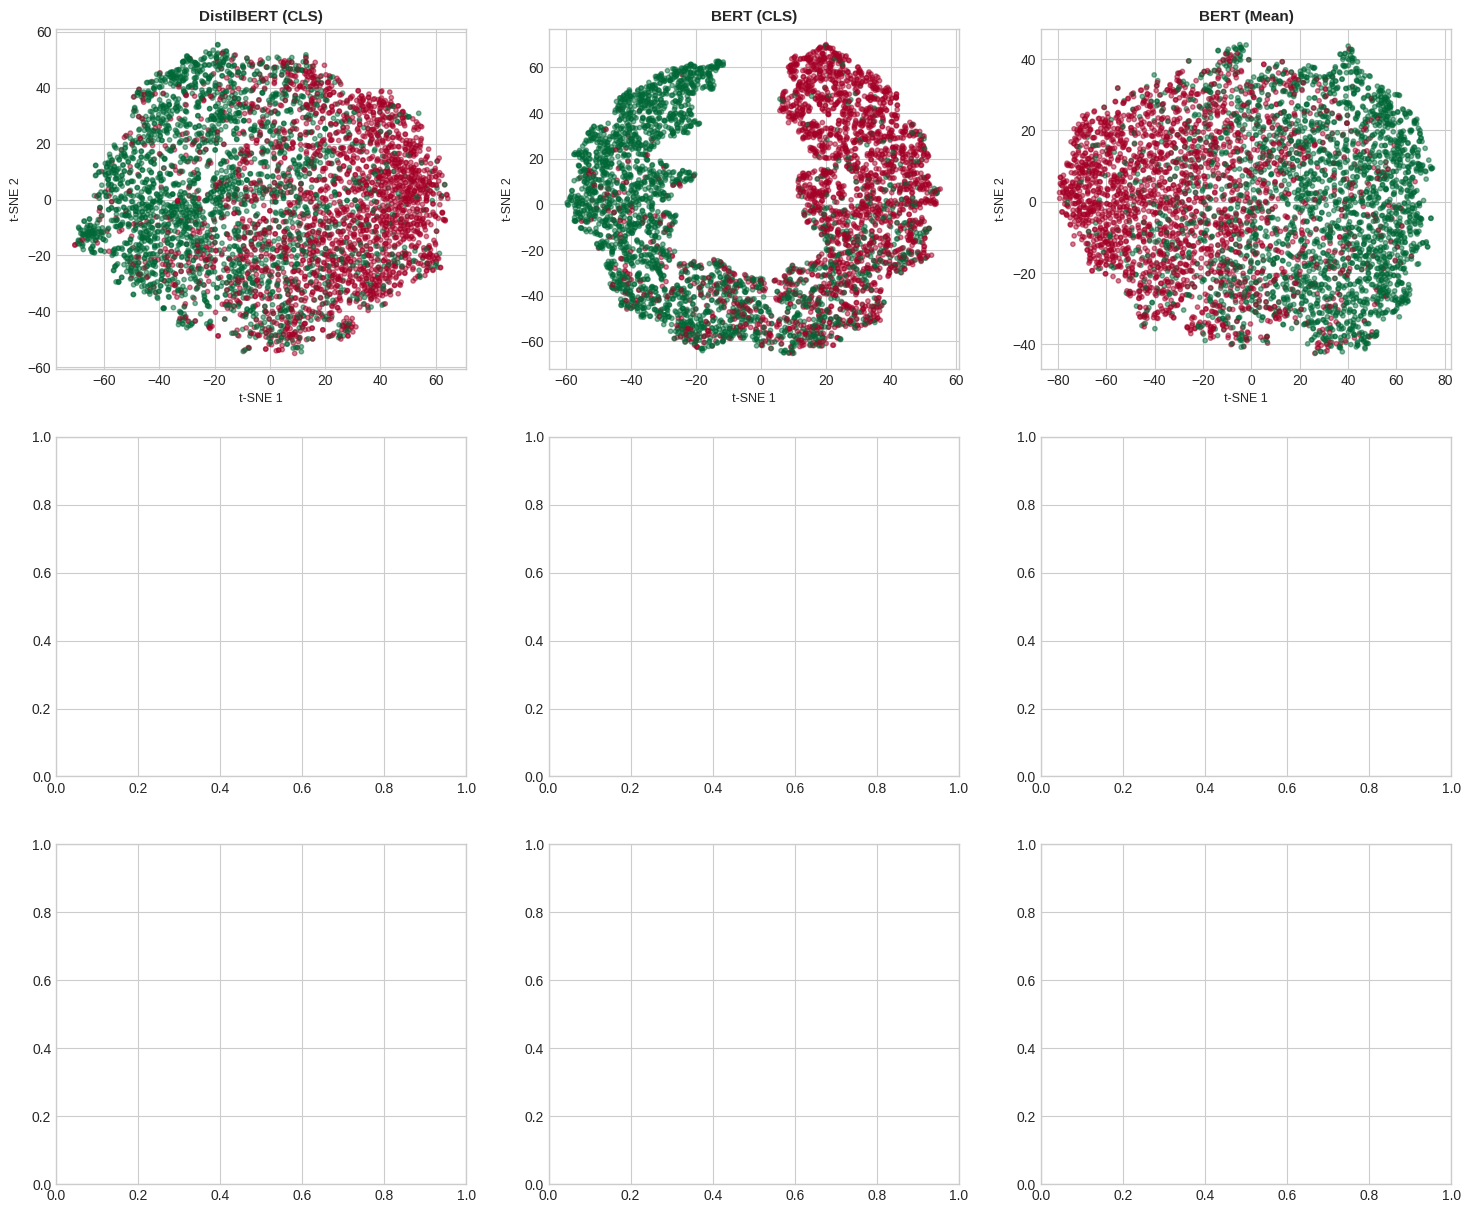

In [ ]:
import os
import gc
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional
import warnings

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve,
    classification_report
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import scipy.sparse

from transformers import (
    BertModel, BertTokenizerFast,
    DistilBertModel, DistilBertTokenizerFast,
    RobertaModel, RobertaTokenizerFast
)

try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False
    print("⚠️ UMAP not installed. Run: pip install umap-learn")

from google.colab import drive
drive.mount('/content/drive')

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

LOAD_DIR = '/content/drive/MyDrive/Final_PAN20_Authorship/processed_states'
MODEL_DIR = '/content/drive/MyDrive/Final_PAN20_Authorship/authorship_results'
OUTPUT_DIR = '/content/drive/MyDrive/Final_PAN20_Authorship/comprehensive_evaluation'
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATASET_TAG = 'pan20_small'
SEED = 42
BATCH_SIZE = 32
EVAL_BATCH_SIZE = 64

torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

class DistilBERTCrossEncoder(nn.Module):
    def __init__(self, dropout=0.3):
        super().__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask, labels=None, **kwargs):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        pooled = self.dropout(cls_output)
        logits = self.classifier(pooled)
        return (logits,)

    def get_embeddings(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
            return outputs.last_hidden_state[:, 0, :]


class BERTCrossEncoder(nn.Module):
    def __init__(self, pooling='cls', dropout=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.pooling = pooling
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, 1)

    def _mean_pooling(self, last_hidden_state, attention_mask):
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_expanded, dim=1)
        sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
        return sum_embeddings / sum_mask

    def forward(self, input_ids, attention_mask, labels=None, **kwargs):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        if self.pooling == 'cls':
            pooled = outputs.pooler_output
        else:
            pooled = self._mean_pooling(outputs.last_hidden_state, attention_mask)
        pooled = self.dropout(pooled)
        logits = self.classifier(pooled)
        return (logits,)

    def get_embeddings(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            if self.pooling == 'cls':
                return outputs.pooler_output
            return self._mean_pooling(outputs.last_hidden_state, attention_mask)


class RoBERTaCrossEncoder(nn.Module):
    def __init__(self, pooling='cls', dropout=0.3):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.pooling = pooling
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, 1)

    def _mean_pooling(self, last_hidden_state, attention_mask):
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_expanded, dim=1)
        sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
        return sum_embeddings / sum_mask

    def forward(self, input_ids, attention_mask, labels=None, **kwargs):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        if self.pooling == 'cls':
            pooled = outputs.last_hidden_state[:, 0, :]
        else:
            pooled = self._mean_pooling(outputs.last_hidden_state, attention_mask)
        pooled = self.dropout(pooled)
        logits = self.classifier(pooled)
        return (logits,)

    def get_embeddings(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
            if self.pooling == 'cls':
                return outputs.last_hidden_state[:, 0, :]
            return self._mean_pooling(outputs.last_hidden_state, attention_mask)


class SiameseBiEncoder(nn.Module):
    def __init__(self, pooling='cls', dropout=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.pooling = pooling
        self.dropout = nn.Dropout(dropout)

    def _mean_pooling(self, last_hidden_state, attention_mask):
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_expanded, dim=1)
        sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
        return sum_embeddings / sum_mask

    def encode(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        if self.pooling == 'cls':
            pooled = outputs.pooler_output
        else:
            pooled = self._mean_pooling(outputs.last_hidden_state, attention_mask)
        return self.dropout(pooled)

    def forward(self, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b, labels=None, **kwargs):
        emb_a = self.encode(input_ids_a, attention_mask_a)
        emb_b = self.encode(input_ids_b, attention_mask_b)
        similarity = F.cosine_similarity(emb_a, emb_b)
        logits = (similarity + 1) / 2
        return (logits, emb_a, emb_b)


class SiameseContrastive(nn.Module):
    def __init__(self, pooling='cls', dropout=0.3, margin=1.0):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.pooling = pooling
        self.dropout = nn.Dropout(dropout)
        self.margin = margin

    def _mean_pooling(self, last_hidden_state, attention_mask):
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_expanded, dim=1)
        sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
        return sum_embeddings / sum_mask

    def encode(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        if self.pooling == 'cls':
            pooled = outputs.pooler_output
        else:
            pooled = self._mean_pooling(outputs.last_hidden_state, attention_mask)
        return F.normalize(self.dropout(pooled), p=2, dim=1)

    def forward(self, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b, labels=None, **kwargs):
        emb_a = self.encode(input_ids_a, attention_mask_a)
        emb_b = self.encode(input_ids_b, attention_mask_b)
        distance = F.pairwise_distance(emb_a, emb_b)
        similarity = 1 / (1 + distance)
        return (similarity, emb_a, emb_b)


class SiameseTriplet(nn.Module):
    def __init__(self, pooling='cls', dropout=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.pooling = pooling
        self.dropout = nn.Dropout(dropout)

    def _mean_pooling(self, last_hidden_state, attention_mask):
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_expanded, dim=1)
        sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
        return sum_embeddings / sum_mask

    def encode(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        if self.pooling == 'cls':
            pooled = outputs.pooler_output
        else:
            pooled = self._mean_pooling(outputs.last_hidden_state, attention_mask)
        return F.normalize(self.dropout(pooled), p=2, dim=1)

    def forward(self, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b, labels=None, **kwargs):
        emb_a = self.encode(input_ids_a, attention_mask_a)
        emb_b = self.encode(input_ids_b, attention_mask_b)
        similarity = F.cosine_similarity(emb_a, emb_b)
        logits = (similarity + 1) / 2
        return (logits, emb_a, emb_b)


class SiameseDataset(Dataset):
    def __init__(self, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b, labels):
        self.input_ids_a = input_ids_a
        self.attention_mask_a = attention_mask_a
        self.input_ids_b = input_ids_b
        self.attention_mask_b = attention_mask_b
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids_a': self.input_ids_a[idx],
            'attention_mask_a': self.attention_mask_a[idx],
            'input_ids_b': self.input_ids_b[idx],
            'attention_mask_b': self.attention_mask_b[idx],
            'labels': self.labels[idx]
        }


class CrossEncoderDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }


MODEL_CONFIGS = {
    'B_DistilBERT_CLS': {
        'class': DistilBERTCrossEncoder,
        'weights': 'distilbert_cls_best.pt',
        'tensor_file': f'{DATASET_TAG}_distilbert-base-uncased_len512_tensors.pt',
        'is_siamese': False,
        'pooling': None,
        'display_name': 'DistilBERT (CLS)',
        'color': '#e74c3c'
    },
    'B+_BERT_CLS': {
        'class': BERTCrossEncoder,
        'weights': 'bert_cls_best.pt',
        'tensor_file': f'{DATASET_TAG}_bert-base-uncased_len512_tensors.pt',
        'is_siamese': False,
        'pooling': 'cls',
        'display_name': 'BERT (CLS)',
        'color': '#3498db'
    },
    'B+_BERT_Mean': {
        'class': BERTCrossEncoder,
        'weights': 'bert_mean_best.pt',
        'tensor_file': f'{DATASET_TAG}_bert-base-uncased_len512_tensors.pt',
        'is_siamese': False,
        'pooling': 'mean',
        'display_name': 'BERT (Mean)',
        'color': '#2ecc71'
    },
    'A-_Siamese_BCE': {
        'class': SiameseBiEncoder,
        'weights': 'siamese_bce_best.pt',
        'tensor_file': f'{DATASET_TAG}_bert-base-uncased_siamese.pt',
        'is_siamese': True,
        'pooling': 'cls',
        'display_name': 'Siamese BCE',
        'color': '#9b59b6'
    },
    'A_Siamese_Contrastive': {
        'class': SiameseContrastive,
        'weights': 'siamese_contrastive_best.pt',
        'tensor_file': f'{DATASET_TAG}_bert-base-uncased_siamese.pt',
        'is_siamese': True,
        'pooling': 'cls',
        'display_name': 'Siamese Contrastive',
        'color': '#f39c12'
    },
    'A_Siamese_Triplet': {
        'class': SiameseTriplet,
        'weights': 'siamese_triplet_best.pt',
        'tensor_file': f'{DATASET_TAG}_bert-base-uncased_siamese.pt',
        'is_siamese': True,
        'pooling': 'cls',
        'display_name': 'Siamese Triplet',
        'color': '#1abc9c'
    },
    'A_RoBERTa': {
        'class': RoBERTaCrossEncoder,
        'weights': 'roberta_cls_best.pt',
        'tensor_file': f'{DATASET_TAG}_roberta-base_len512_tensors.pt',
        'is_siamese': False,
        'pooling': 'cls',
        'display_name': 'RoBERTa (CLS)',
        'color': '#e91e63'
    }
}


def evaluate_cross_encoder(model, test_loader, device) -> Tuple[Dict, np.ndarray, np.ndarray, np.ndarray]:
    model.eval()
    all_probs = []
    all_labels = []
    all_embeddings = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs[0]
            probs = torch.sigmoid(logits).cpu().numpy().flatten()

            embeddings = model.get_embeddings(input_ids, attention_mask)

            all_probs.extend(probs)
            all_labels.extend(labels.numpy())
            all_embeddings.extend(embeddings.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    all_embeddings = np.array(all_embeddings)
    all_preds = (all_probs > 0.5).astype(int)

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, zero_division=0),
        'recall': recall_score(all_labels, all_preds, zero_division=0),
        'f1': f1_score(all_labels, all_preds, zero_division=0),
        'auc': roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels)) > 1 else 0.0
    }

    return metrics, all_probs, all_labels, all_embeddings


def evaluate_siamese(model, test_loader, device) -> Tuple[Dict, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    model.eval()
    all_probs = []
    all_labels = []
    all_emb_a = []
    all_emb_b = []

    with torch.no_grad():
        for batch in test_loader:
            batch_device = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch_device)

            probs = outputs[0].cpu().numpy()
            emb_a = outputs[1].cpu().numpy()
            emb_b = outputs[2].cpu().numpy()

            all_probs.extend(probs)
            all_labels.extend(batch['labels'].numpy())
            all_emb_a.extend(emb_a)
            all_emb_b.extend(emb_b)

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    all_emb_a = np.array(all_emb_a)
    all_emb_b = np.array(all_emb_b)
    all_preds = (all_probs > 0.5).astype(int)

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, zero_division=0),
        'recall': recall_score(all_labels, all_preds, zero_division=0),
        'f1': f1_score(all_labels, all_preds, zero_division=0),
        'auc': roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels)) > 1 else 0.0
    }

    all_embeddings = np.vstack([all_emb_a, all_emb_b])

    return metrics, all_probs, all_labels, all_embeddings


def evaluate_baseline(train_idx, test_idx, labels) -> Tuple[Dict, np.ndarray, np.ndarray]:
    print("  Loading baseline model...")

    class OptimizedCharacterNGramBaseline:
        def __init__(self, ngram_range=(3, 4), max_features=30000):
            from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer
            self.hasher = HashingVectorizer(
                analyzer='char', ngram_range=ngram_range, n_features=max_features,
                lowercase=True, norm=None, alternate_sign=False
            )
            self.tfidf_transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True)
            self.hashed_matrix = None

    ngram_paths = {
        'model': os.path.join(LOAD_DIR, f"{DATASET_TAG}_char_ngram_n3-4_feat30000_model.pkl"),
        'matrix': os.path.join(LOAD_DIR, f"{DATASET_TAG}_char_ngram_n3-4_feat30000_matrix.npz")
    }

    if not os.path.exists(ngram_paths['model']):
        print("  ⚠️ Baseline model not found")
        return None, None, None

    with open(ngram_paths['model'], 'rb') as f:
        char_model = pickle.load(f)

    char_model.hashed_matrix = scipy.sparse.load_npz(ngram_paths['matrix'])
    X_all = char_model.tfidf_transformer.transform(char_model.hashed_matrix)

    X_train = X_all[train_idx]
    y_train = labels[train_idx].numpy()
    X_test = X_all[test_idx]
    y_test = labels[test_idx].numpy()

    print("  Fitting Logistic Regression...")
    clf = LogisticRegression(random_state=SEED, max_iter=1000, n_jobs=-1)
    clf.fit(X_train, y_train)

    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'auc': roc_auc_score(y_test, y_pred_proba)
    }

    del char_model
    gc.collect()

    return metrics, y_pred_proba, y_test


def plot_metrics_comparison(all_results: Dict, save_dir: str):
    if not all_results:
        print("No results to plot")
        return

    models = list(all_results.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']

    colors = [MODEL_CONFIGS.get(m, {}).get('color', '#333333') for m in models]
    display_names = [MODEL_CONFIGS.get(m, {}).get('display_name', m) for m in models]

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        values = [all_results[m].get(metric, 0) for m in models]
        bars = axes[i].bar(range(len(models)), values, color=colors, edgecolor='black', linewidth=0.5)

        for bar, val in zip(bars, values):
            axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

        axes[i].set_xticks(range(len(models)))
        axes[i].set_xticklabels(display_names, rotation=45, ha='right', fontsize=9)
        axes[i].set_ylabel(metric.upper(), fontsize=11)
        axes[i].set_title(f'{metric.upper()} Comparison', fontsize=12, fontweight='bold')
        axes[i].set_ylim([0, 1.15])
        axes[i].grid(True, alpha=0.3, axis='y')
        axes[i].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random Baseline')

    x = np.arange(len(models))
    width = 0.15

    for i, metric in enumerate(metrics):
        values = [all_results[m].get(metric, 0) for m in models]
        offset = (i - len(metrics)/2 + 0.5) * width
        axes[5].bar(x + offset, values, width, label=metric.upper())

    axes[5].set_xticks(x)
    axes[5].set_xticklabels(display_names, rotation=45, ha='right', fontsize=9)
    axes[5].set_ylabel('Score', fontsize=11)
    axes[5].set_title('All Metrics Comparison', fontsize=12, fontweight='bold')
    axes[5].legend(loc='upper right', fontsize=8)
    axes[5].set_ylim([0, 1.15])
    axes[5].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    save_path = os.path.join(save_dir, 'metrics_comparison_bars.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✓ Metrics comparison saved to: {save_path}")

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]

    for model in models:
        values = [all_results[model].get(m, 0) for m in metrics]
        values += values[:1]
        color = MODEL_CONFIGS.get(model, {}).get('color', '#333333')
        display_name = MODEL_CONFIGS.get(model, {}).get('display_name', model)
        ax.plot(angles, values, 'o-', linewidth=2, label=display_name, color=color)
        ax.fill(angles, values, alpha=0.1, color=color)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([m.upper() for m in metrics], fontsize=11)
    ax.set_ylim([0, 1])
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=9)
    ax.set_title('Model Performance Radar Chart', fontsize=14, fontweight='bold', pad=20)

    plt.tight_layout()
    save_path = os.path.join(save_dir, 'metrics_radar_chart.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✓ Radar chart saved to: {save_path}")


def plot_confusion_matrices(all_predictions: Dict, all_labels: Dict, save_dir: str):
    models = list(all_predictions.keys())
    n_models = len(models)

    cols = 3
    rows = (n_models + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    axes = axes.flatten() if n_models > 1 else [axes]

    for i, model in enumerate(models):
        probs = all_predictions[model]
        labels = all_labels[model]
        preds = (probs > 0.5).astype(int)

        cm = confusion_matrix(labels, preds)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        display_name = MODEL_CONFIGS.get(model, {}).get('display_name', model)

        sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                   xticklabels=['Different', 'Same'],
                   yticklabels=['Different', 'Same'],
                   ax=axes[i], cbar=True,
                   annot_kws={'size': 12})

        for j in range(2):
            for k in range(2):
                axes[i].text(k + 0.5, j + 0.75, f'(n={cm[j,k]})',
                           ha='center', va='center', fontsize=9, color='gray')

        axes[i].set_xlabel('Predicted', fontsize=10)
        axes[i].set_ylabel('True', fontsize=10)
        axes[i].set_title(f'{display_name}', fontsize=11, fontweight='bold')

    for i in range(n_models, len(axes)):
        axes[i].axis('off')

    plt.suptitle('Confusion Matrices (Normalized)', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    save_path = os.path.join(save_dir, 'confusion_matrices_grid.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✓ Confusion matrices saved to: {save_path}")


def plot_roc_curves(all_predictions: Dict, all_labels: Dict, save_dir: str):
    fig, ax = plt.subplots(figsize=(10, 8))

    for model in all_predictions.keys():
        probs = all_predictions[model]
        labels = all_labels[model]

        fpr, tpr, _ = roc_curve(labels, probs)
        auc = roc_auc_score(labels, probs)

        color = MODEL_CONFIGS.get(model, {}).get('color', '#333333')
        display_name = MODEL_CONFIGS.get(model, {}).get('display_name', model)

        ax.plot(fpr, tpr, label=f'{display_name} (AUC={auc:.3f})',
               color=color, linewidth=2)

    ax.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.500)', linewidth=1)
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    plt.tight_layout()
    save_path = os.path.join(save_dir, 'roc_curves_comparison.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✓ ROC curves saved to: {save_path}")


def plot_precision_recall_curves(all_predictions: Dict, all_labels: Dict, save_dir: str):
    fig, ax = plt.subplots(figsize=(10, 8))

    for model in all_predictions.keys():
        probs = all_predictions[model]
        labels = all_labels[model]

        precision, recall, _ = precision_recall_curve(labels, probs)

        color = MODEL_CONFIGS.get(model, {}).get('color', '#333333')
        display_name = MODEL_CONFIGS.get(model, {}).get('display_name', model)

        ax.plot(recall, precision, label=display_name, color=color, linewidth=2)

    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title('Precision-Recall Curves Comparison', fontsize=14, fontweight='bold')
    ax.legend(loc='lower left', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    plt.tight_layout()
    save_path = os.path.join(save_dir, 'precision_recall_curves.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✓ Precision-Recall curves saved to: {save_path}")


def plot_embeddings_tsne_umap(all_embeddings: Dict, all_labels: Dict, save_dir: str):
    print("\n📊 Generating embedding visualizations...")

    models = list(all_embeddings.keys())
    n_models = len(models)

    cols = 3
    rows = (n_models + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
    axes = axes.flatten() if n_models > 1 else [axes]

    for i, model in enumerate(models):
        print(f"  Computing t-SNE for {model}...")
        embeddings = all_embeddings[model]

        max_samples = 5000
        if len(embeddings) > max_samples:
            idx = np.random.choice(len(embeddings), max_samples, replace=False)
            embeddings_sample = embeddings[idx]
            if model in all_labels and len(all_labels[model]) == len(embeddings) // 2:
                labels_sample = np.tile(all_labels[model][idx[:max_samples//2]], 2)[:max_samples]
            else:
                labels_sample = all_labels.get(model, np.zeros(max_samples))[idx] if model in all_labels else np.zeros(max_samples)
        else:
            embeddings_sample = embeddings
            if model in all_labels:
                if len(all_labels[model]) == len(embeddings) // 2:
                    labels_sample = np.tile(all_labels[model], 2)
                else:
                    labels_sample = all_labels[model]
            else:
                labels_sample = np.zeros(len(embeddings))

        if embeddings_sample.shape[1] > 50:
            pca = PCA(n_components=50, random_state=SEED)
            embeddings_reduced = pca.fit_transform(embeddings_sample)
        else:
            embeddings_reduced = embeddings_sample

        tsne = TSNE(n_components=2, random_state=SEED, perplexity=min(30, len(embeddings_sample)//4), n_iter=1000)
        tsne_result = tsne.fit_transform(embeddings_reduced)

        display_name = MODEL_CONFIGS.get(model, {}).get('display_name', model)

        scatter = axes[i].scatter(tsne_result[:, 0], tsne_result[:, 1],
                                  c=labels_sample, cmap='RdYlGn', alpha=0.5, s=10)
        axes[i].set_title(f'{display_name}', fontsize=11, fontweight='bold')
        axes[i].set_xlabel('t-SNE 1', fontsize=9)
        axes[i].set_ylabel('t-SNE 2', fontsize=9)

    for i in range(n_models, len(axes)):
        axes[i].axis('off')

    plt.suptitle('t-SNE Embeddings (Green=Same Author, Red=Different)', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    save_path = os.path.join(save_dir, 'tsne_embeddings_all_models.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✓ t-SNE visualization saved to: {save_path}")

    if UMAP_AVAILABLE:
        fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
        axes = axes.flatten() if n_models > 1 else [axes]

        for i, model in enumerate(models):
            print(f"  Computing UMAP for {model}...")
            embeddings = all_embeddings[model]

            if len(embeddings) > max_samples:
                idx = np.random.choice(len(embeddings), max_samples, replace=False)
                embeddings_sample = embeddings[idx]
                if model in all_labels and len(all_labels[model]) == len(embeddings) // 2:
                    labels_sample = np.tile(all_labels[model][idx[:max_samples//2]], 2)[:max_samples]
                else:
                    labels_sample = all_labels.get(model, np.zeros(max_samples))[idx] if model in all_labels else np.zeros(max_samples)
            else:
                embeddings_sample = embeddings
                if model in all_labels:
                    if len(all_labels[model]) == len(embeddings) // 2:
                        labels_sample = np.tile(all_labels[model], 2)
                    else:
                        labels_sample = all_labels[model]
                else:
                    labels_sample = np.zeros(len(embeddings))

            reducer = umap.UMAP(n_components=2, random_state=SEED, n_neighbors=15, min_dist=0.1)
            umap_result = reducer.fit_transform(embeddings_sample)

            display_name = MODEL_CONFIGS.get(model, {}).get('display_name', model)

            scatter = axes[i].scatter(umap_result[:, 0], umap_result[:, 1],
                                      c=labels_sample, cmap='RdYlGn', alpha=0.5, s=10)
            axes[i].set_title(f'{display_name}', fontsize=11, fontweight='bold')
            axes[i].set_xlabel('UMAP 1', fontsize=9)
            axes[i].set_ylabel('UMAP 2', fontsize=9)

        for i in range(n_models, len(axes)):
            axes[i].axis('off')

        plt.suptitle('UMAP Embeddings (Green=Same Author, Red=Different)', fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        save_path = os.path.join(save_dir, 'umap_embeddings_all_models.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"✓ UMAP visualization saved to: {save_path}")


def plot_heatmap_results(all_results: Dict, save_dir: str):
    df = pd.DataFrame(all_results).T

    df.index = [MODEL_CONFIGS.get(m, {}).get('display_name', m) for m in df.index]
    df.columns = [c.upper() for c in df.columns]

    fig, ax = plt.subplots(figsize=(10, 8))

    sns.heatmap(df, annot=True, fmt='.3f', cmap='RdYlGn',
               linewidths=0.5, ax=ax, vmin=0.5, vmax=1.0,
               annot_kws={'size': 12, 'weight': 'bold'})

    ax.set_title('Model Performance Heatmap', fontsize=14, fontweight='bold')
    ax.set_xlabel('Metric', fontsize=12)
    ax.set_ylabel('Model', fontsize=12)

    plt.tight_layout()
    save_path = os.path.join(save_dir, 'performance_heatmap.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✓ Performance heatmap saved to: {save_path}")


def create_results_table(all_results: Dict, save_dir: str):
    df = pd.DataFrame(all_results).T
    df.index.name = 'Model'

    df['Display Name'] = [MODEL_CONFIGS.get(m, {}).get('display_name', m) for m in df.index]

    cols = ['Display Name', 'accuracy', 'precision', 'recall', 'f1', 'auc']
    df = df[[c for c in cols if c in df.columns]]

    for col in df.columns:
        if col != 'Display Name':
            df[col] = df[col].round(4)

    df = df.sort_values('auc', ascending=False)

    csv_path = os.path.join(save_dir, 'comprehensive_results.csv')
    df.to_csv(csv_path)
    print(f"✓ Results table saved to: {csv_path}")

    print("\n" + "="*80)
    print("COMPREHENSIVE RESULTS TABLE")
    print("="*80)
    print(df.to_string())
    print("="*80)

    best_model = df['auc'].idxmax()
    best_display = df.loc[best_model, 'Display Name']
    print(f"\n🏆 BEST MODEL: {best_display}")
    print(f"   AUC: {df.loc[best_model, 'auc']:.4f}")
    print(f"   F1:  {df.loc[best_model, 'f1']:.4f}")

    return df


def main():
    print("="*70)
    print("COMPREHENSIVE MODEL EVALUATION")
    print("Authorship Verification - All Models Standardized Comparison")
    print("Team Member: Harit Tarwani (002567547)")
    print("="*70)

    print("\n📁 Loading data...")
    labels_path = os.path.join(LOAD_DIR, f"{DATASET_TAG}_labels.pt")
    labels = torch.load(labels_path, weights_only=False)

    indices = np.arange(len(labels))
    train_idx, temp_idx = train_test_split(indices, test_size=0.2, random_state=SEED, stratify=labels)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=SEED, stratify=labels[temp_idx])

    print(f"Total samples: {len(labels)}")
    print(f"Test samples: {len(test_idx)}")

    all_results = {}
    all_predictions = {}
    all_labels_dict = {}
    all_embeddings = {}

    for model_name, config in MODEL_CONFIGS.items():
        weights_path = os.path.join(MODEL_DIR, config['weights'])

        if not os.path.exists(weights_path):
            print(f"\n⚠️ {model_name}: Weights not found at {weights_path}")
            continue

        print(f"\n{'='*50}")
        print(f"Evaluating: {config['display_name']}")
        print(f"{'='*50}")

        try:
            tensor_path = os.path.join(LOAD_DIR, config['tensor_file'])
            if not os.path.exists(tensor_path):
                print(f"  ⚠️ Tensor file not found: {tensor_path}")
                continue

            data = torch.load(tensor_path, weights_only=False)

            if config['is_siamese']:
                test_dataset = SiameseDataset(
                    data['input_ids_a'][test_idx],
                    data['attention_mask_a'][test_idx],
                    data['input_ids_b'][test_idx],
                    data['attention_mask_b'][test_idx],
                    labels[test_idx]
                )
            else:
                test_dataset = CrossEncoderDataset(
                    data['input_ids'][test_idx],
                    data['attention_mask'][test_idx],
                    labels[test_idx]
                )

            del data
            gc.collect()

            test_loader = DataLoader(test_dataset, batch_size=EVAL_BATCH_SIZE, shuffle=False, num_workers=0)

            if config['pooling'] is not None:
                model = config['class'](pooling=config['pooling'])
            else:
                model = config['class']()

            model.load_state_dict(torch.load(weights_path, map_location=device))
            model = model.to(device)
            model.eval()

            if config['is_siamese']:
                metrics, probs, true_labels, embeddings = evaluate_siamese(model, test_loader, device)
            else:
                metrics, probs, true_labels, embeddings = evaluate_cross_encoder(model, test_loader, device)

            all_results[model_name] = metrics
            all_predictions[model_name] = probs
            all_labels_dict[model_name] = true_labels
            all_embeddings[model_name] = embeddings

            print(f"  ✓ Accuracy: {metrics['accuracy']:.4f}")
            print(f"  ✓ Precision: {metrics['precision']:.4f}")
            print(f"  ✓ Recall: {metrics['recall']:.4f}")
            print(f"  ✓ F1: {metrics['f1']:.4f}")
            print(f"  ✓ AUC: {metrics['auc']:.4f}")

            del model, test_dataset, test_loader
            gc.collect()
            torch.cuda.empty_cache()

        except Exception as e:
            print(f"  ❌ Error evaluating {model_name}: {e}")
            import traceback
            traceback.print_exc()

    print(f"\n{'='*50}")
    print("Evaluating: Character N-gram Baseline")
    print(f"{'='*50}")

    try:
        baseline_metrics, baseline_probs, baseline_labels = evaluate_baseline(train_idx, test_idx, labels)
        if baseline_metrics is not None:
            all_results['Baseline_CharNgram'] = baseline_metrics
            all_predictions['Baseline_CharNgram'] = baseline_probs
            all_labels_dict['Baseline_CharNgram'] = baseline_labels

            MODEL_CONFIGS['Baseline_CharNgram'] = {
                'display_name': 'Char N-gram Baseline',
                'color': '#7f8c8d'
            }

            print(f"  ✓ Accuracy: {baseline_metrics['accuracy']:.4f}")
            print(f"  ✓ F1: {baseline_metrics['f1']:.4f}")
            print(f"  ✓ AUC: {baseline_metrics['auc']:.4f}")
    except Exception as e:
        print(f"  ❌ Baseline evaluation failed: {e}")

    print("\n" + "="*70)
    print("GENERATING VISUALIZATIONS")
    print("="*70)

    plot_metrics_comparison(all_results, OUTPUT_DIR)

    plot_confusion_matrices(all_predictions, all_labels_dict, OUTPUT_DIR)

    plot_roc_curves(all_predictions, all_labels_dict, OUTPUT_DIR)

    plot_precision_recall_curves(all_predictions, all_labels_dict, OUTPUT_DIR)

    plot_heatmap_results(all_results, OUTPUT_DIR)

    if all_embeddings:
        plot_embeddings_tsne_umap(all_embeddings, all_labels_dict, OUTPUT_DIR)

    results_df = create_results_table(all_results, OUTPUT_DIR)

    print("\n" + "="*70)
    print("EVALUATION COMPLETE")
    print("="*70)
    print(f"\n📁 All outputs saved to: {OUTPUT_DIR}")
    print("\nGenerated files:")
    print("  • metrics_comparison_bars.png")
    print("  • metrics_radar_chart.png")
    print("  • confusion_matrices_grid.png")
    print("  • roc_curves_comparison.png")
    print("  • precision_recall_curves.png")
    print("  • performance_heatmap.png")
    print("  • tsne_embeddings_all_models.png")
    if UMAP_AVAILABLE:
        print("  • umap_embeddings_all_models.png")
    print("  • comprehensive_results.csv")


if __name__ == "__main__":
    main()

In [ ]:
import os
import gc
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from typing import Dict, List, Tuple, Optional
import warnings

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import scipy.sparse

from transformers import (
    BertModel, BertTokenizerFast,
    DistilBertModel, DistilBertTokenizerFast,
    RobertaModel, RobertaTokenizerFast
)

from google.colab import drive
drive.mount('/content/drive')

warnings.filterwarnings('ignore')

LOAD_DIR = '/content/drive/MyDrive/Final_PAN20_Authorship/processed_states'
MODEL_DIR = '/content/drive/MyDrive/Final_PAN20_Authorship/authorship_results'
OUTPUT_DIR = '/content/drive/MyDrive/Final_PAN20_Authorship/pair_analysis'
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATASET_TAG = 'pan20_small'
SEED = 42
NUM_PAIRS = 100
TEXT_PREVIEW_LENGTH = 500

torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

class DistilBERTCrossEncoder(nn.Module):
    def __init__(self, dropout=0.3):
        super().__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask, **kwargs):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        pooled = self.dropout(cls_output)
        logits = self.classifier(pooled)
        return (logits,)


class BERTCrossEncoder(nn.Module):
    def __init__(self, pooling='cls', dropout=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.pooling = pooling
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, 1)

    def _mean_pooling(self, last_hidden_state, attention_mask):
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_expanded, dim=1)
        sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
        return sum_embeddings / sum_mask

    def forward(self, input_ids, attention_mask, **kwargs):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        if self.pooling == 'cls':
            pooled = outputs.pooler_output
        else:
            pooled = self._mean_pooling(outputs.last_hidden_state, attention_mask)
        pooled = self.dropout(pooled)
        logits = self.classifier(pooled)
        return (logits,)


class RoBERTaCrossEncoder(nn.Module):
    def __init__(self, pooling='cls', dropout=0.3):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.pooling = pooling
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, 1)

    def _mean_pooling(self, last_hidden_state, attention_mask):
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_expanded, dim=1)
        sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
        return sum_embeddings / sum_mask

    def forward(self, input_ids, attention_mask, **kwargs):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        if self.pooling == 'cls':
            pooled = outputs.last_hidden_state[:, 0, :]
        else:
            pooled = self._mean_pooling(outputs.last_hidden_state, attention_mask)
        pooled = self.dropout(pooled)
        logits = self.classifier(pooled)
        return (logits,)


class SiameseBiEncoder(nn.Module):
    def __init__(self, pooling='cls', dropout=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.pooling = pooling
        self.dropout = nn.Dropout(dropout)

    def _mean_pooling(self, last_hidden_state, attention_mask):
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_expanded, dim=1)
        sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
        return sum_embeddings / sum_mask

    def encode(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        if self.pooling == 'cls':
            pooled = outputs.pooler_output
        else:
            pooled = self._mean_pooling(outputs.last_hidden_state, attention_mask)
        return self.dropout(pooled)

    def forward(self, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b, **kwargs):
        emb_a = self.encode(input_ids_a, attention_mask_a)
        emb_b = self.encode(input_ids_b, attention_mask_b)
        similarity = F.cosine_similarity(emb_a, emb_b)
        logits = (similarity + 1) / 2
        return (logits,)


class SiameseContrastive(nn.Module):
    def __init__(self, pooling='cls', dropout=0.3, margin=1.0):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.pooling = pooling
        self.dropout = nn.Dropout(dropout)
        self.margin = margin

    def _mean_pooling(self, last_hidden_state, attention_mask):
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_expanded, dim=1)
        sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
        return sum_embeddings / sum_mask

    def encode(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        if self.pooling == 'cls':
            pooled = outputs.pooler_output
        else:
            pooled = self._mean_pooling(outputs.last_hidden_state, attention_mask)
        return F.normalize(self.dropout(pooled), p=2, dim=1)

    def forward(self, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b, **kwargs):
        emb_a = self.encode(input_ids_a, attention_mask_a)
        emb_b = self.encode(input_ids_b, attention_mask_b)
        distance = F.pairwise_distance(emb_a, emb_b)
        similarity = 1 / (1 + distance)
        return (similarity,)


class SiameseTriplet(nn.Module):
    def __init__(self, pooling='cls', dropout=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.pooling = pooling
        self.dropout = nn.Dropout(dropout)

    def _mean_pooling(self, last_hidden_state, attention_mask):
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_expanded, dim=1)
        sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
        return sum_embeddings / sum_mask

    def encode(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        if self.pooling == 'cls':
            pooled = outputs.pooler_output
        else:
            pooled = self._mean_pooling(outputs.last_hidden_state, attention_mask)
        return F.normalize(self.dropout(pooled), p=2, dim=1)

    def forward(self, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b, **kwargs):
        emb_a = self.encode(input_ids_a, attention_mask_a)
        emb_b = self.encode(input_ids_b, attention_mask_b)
        similarity = F.cosine_similarity(emb_a, emb_b)
        logits = (similarity + 1) / 2
        return (logits,)


MODEL_CONFIGS = {
    'DistilBERT': {
        'class': DistilBERTCrossEncoder,
        'weights': 'distilbert_cls_best.pt',
        'tensor_key': 'distilbert',
        'is_siamese': False,
        'pooling': None,
        'tokenizer': 'distilbert-base-uncased'
    },
    'BERT_CLS': {
        'class': BERTCrossEncoder,
        'weights': 'bert_cls_best.pt',
        'tensor_key': 'bert',
        'is_siamese': False,
        'pooling': 'cls',
        'tokenizer': 'bert-base-uncased'
    },
    'BERT_Mean': {
        'class': BERTCrossEncoder,
        'weights': 'bert_mean_best.pt',
        'tensor_key': 'bert',
        'is_siamese': False,
        'pooling': 'mean',
        'tokenizer': 'bert-base-uncased'
    },
    'Siamese_BCE': {
        'class': SiameseBiEncoder,
        'weights': 'siamese_bce_best.pt',
        'tensor_key': 'siamese',
        'is_siamese': True,
        'pooling': 'cls',
        'tokenizer': 'bert-base-uncased'
    },
    'Siamese_Contrastive': {
        'class': SiameseContrastive,
        'weights': 'siamese_contrastive_best.pt',
        'tensor_key': 'siamese',
        'is_siamese': True,
        'pooling': 'cls',
        'tokenizer': 'bert-base-uncased'
    },
    'Siamese_Triplet': {
        'class': SiameseTriplet,
        'weights': 'siamese_triplet_best.pt',
        'tensor_key': 'siamese',
        'is_siamese': True,
        'pooling': 'cls',
        'tokenizer': 'bert-base-uncased'
    },
    'RoBERTa': {
        'class': RoBERTaCrossEncoder,
        'weights': 'roberta_cls_best.pt',
        'tensor_key': 'roberta',
        'is_siamese': False,
        'pooling': 'cls',
        'tokenizer': 'roberta-base'
    }
}


def decode_cross_encoder_text(tokenizer, input_ids: torch.Tensor) -> Tuple[str, str]:
    full_text = tokenizer.decode(input_ids, skip_special_tokens=False)

    sep_token = tokenizer.sep_token or '[SEP]'
    cls_token = tokenizer.cls_token or '[CLS]'
    pad_token = tokenizer.pad_token or '[PAD]'

    full_text = full_text.replace(cls_token, '').replace(pad_token, '').strip()
    parts = full_text.split(sep_token)

    if len(parts) >= 2:
        doc1 = parts[0].strip()
        doc2 = parts[1].strip()
    else:
        doc1 = full_text
        doc2 = "[Could not separate]"

    return doc1, doc2


def decode_siamese_text(tokenizer, input_ids_a: torch.Tensor, input_ids_b: torch.Tensor) -> Tuple[str, str]:
    doc1 = tokenizer.decode(input_ids_a, skip_special_tokens=True).strip()
    doc2 = tokenizer.decode(input_ids_b, skip_special_tokens=True).strip()
    return doc1, doc2


def get_prediction_cross_encoder(model, input_ids, attention_mask, device) -> Tuple[float, int]:
    model.eval()
    with torch.no_grad():
        input_ids = input_ids.unsqueeze(0).to(device)
        attention_mask = attention_mask.unsqueeze(0).to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs[0]
        prob = torch.sigmoid(logits).cpu().item()
        pred = 1 if prob > 0.5 else 0
    return prob, pred


def get_prediction_siamese(model, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b, device) -> Tuple[float, int]:
    model.eval()
    with torch.no_grad():
        input_ids_a = input_ids_a.unsqueeze(0).to(device)
        attention_mask_a = attention_mask_a.unsqueeze(0).to(device)
        input_ids_b = input_ids_b.unsqueeze(0).to(device)
        attention_mask_b = attention_mask_b.unsqueeze(0).to(device)

        outputs = model(
            input_ids_a=input_ids_a,
            attention_mask_a=attention_mask_a,
            input_ids_b=input_ids_b,
            attention_mask_b=attention_mask_b
        )
        prob = outputs[0].cpu().item()
        pred = 1 if prob > 0.5 else 0
    return prob, pred


def main():
    print("="*70)
    print("PAIR-LEVEL ANALYSIS")
    print("Authorship Verification - Manual Qualitative Analysis")
    print("Team Member: Harit Tarwani (002567547)")
    print("="*70)

    print("\n📁 Loading data...")
    labels_path = os.path.join(LOAD_DIR, f"{DATASET_TAG}_labels.pt")
    labels = torch.load(labels_path, weights_only=False)

    indices = np.arange(len(labels))
    train_idx, temp_idx = train_test_split(indices, test_size=0.2, random_state=SEED, stratify=labels)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=SEED, stratify=labels[temp_idx])

    print(f"Test set size: {len(test_idx)}")

    print(f"\n📊 Sampling {NUM_PAIRS} pairs (balanced)...")

    test_labels = labels[test_idx].numpy()
    same_author_idx = np.where(test_labels == 1)[0]
    diff_author_idx = np.where(test_labels == 0)[0]

    n_same = NUM_PAIRS // 2
    n_diff = NUM_PAIRS - n_same

    np.random.seed(SEED)
    sampled_same = np.random.choice(same_author_idx, min(n_same, len(same_author_idx)), replace=False)
    sampled_diff = np.random.choice(diff_author_idx, min(n_diff, len(diff_author_idx)), replace=False)

    sampled_indices = np.concatenate([sampled_same, sampled_diff])
    np.random.shuffle(sampled_indices)

    print(f"  Same author pairs: {len(sampled_same)}")
    print(f"  Different author pairs: {len(sampled_diff)}")
    print(f"  Total pairs: {len(sampled_indices)}")

    print("\n📁 Loading tensor files...")

    tensor_files = {
        'distilbert': os.path.join(LOAD_DIR, f"{DATASET_TAG}_distilbert-base-uncased_len512_tensors.pt"),
        'bert': os.path.join(LOAD_DIR, f"{DATASET_TAG}_bert-base-uncased_len512_tensors.pt"),
        'roberta': os.path.join(LOAD_DIR, f"{DATASET_TAG}_roberta-base_len512_tensors.pt"),
        'siamese': os.path.join(LOAD_DIR, f"{DATASET_TAG}_bert-base-uncased_siamese.pt")
    }

    tensors = {}
    for key, path in tensor_files.items():
        if os.path.exists(path):
            tensors[key] = torch.load(path, weights_only=False)
            print(f"  ✓ Loaded {key}")
        else:
            print(f"  ⚠️ Not found: {key}")

    print("\n📁 Loading tokenizers...")
    tokenizers = {
        'bert-base-uncased': BertTokenizerFast.from_pretrained('bert-base-uncased'),
        'distilbert-base-uncased': DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased'),
        'roberta-base': RobertaTokenizerFast.from_pretrained('roberta-base')
    }
    print("  ✓ Tokenizers loaded")

    print("\n📁 Loading models...")

    models = {}
    for model_name, config in MODEL_CONFIGS.items():
        weights_path = os.path.join(MODEL_DIR, config['weights'])

        if not os.path.exists(weights_path):
            print(f"  ⚠️ {model_name}: Weights not found")
            continue

        try:
            if config['pooling'] is not None:
                model = config['class'](pooling=config['pooling'])
            else:
                model = config['class']()

            model.load_state_dict(torch.load(weights_path, map_location=device))
            model = model.to(device)
            model.eval()
            models[model_name] = model
            print(f"  ✓ {model_name}")
        except Exception as e:
            print(f"  ❌ {model_name}: {e}")

    print(f"\n🔍 Analyzing {len(sampled_indices)} pairs across {len(models)} models...")

    results = []
    detailed_report = []

    detailed_report.append("="*100)
    detailed_report.append("PAIR-LEVEL ANALYSIS REPORT")
    detailed_report.append(f"Total Pairs Analyzed: {len(sampled_indices)}")
    detailed_report.append(f"Models Evaluated: {', '.join(models.keys())}")
    detailed_report.append("="*100)

    for i, local_idx in enumerate(sampled_indices):
        global_idx = test_idx[local_idx]
        true_label = int(labels[global_idx].item())
        true_label_str = "Same Author" if true_label == 1 else "Different Author"

        pair_result = {
            'pair_id': i + 1,
            'test_idx': local_idx,
            'global_idx': global_idx,
            'true_label': true_label,
            'true_label_str': true_label_str
        }

        if 'bert' in tensors:
            bert_tokenizer = tokenizers['bert-base-uncased']
            input_ids = tensors['bert']['input_ids'][global_idx]
            doc1, doc2 = decode_cross_encoder_text(bert_tokenizer, input_ids)
        elif 'siamese' in tensors:
            bert_tokenizer = tokenizers['bert-base-uncased']
            doc1 = bert_tokenizer.decode(tensors['siamese']['input_ids_a'][global_idx], skip_special_tokens=True)
            doc2 = bert_tokenizer.decode(tensors['siamese']['input_ids_b'][global_idx], skip_special_tokens=True)
        else:
            doc1 = "[Text not available]"
            doc2 = "[Text not available]"

        pair_result['doc1_preview'] = doc1[:TEXT_PREVIEW_LENGTH]
        pair_result['doc2_preview'] = doc2[:TEXT_PREVIEW_LENGTH]
        pair_result['doc1_full'] = doc1
        pair_result['doc2_full'] = doc2

        correct_models = []
        incorrect_models = []

        for model_name, model in models.items():
            config = MODEL_CONFIGS[model_name]
            tensor_key = config['tensor_key']

            if tensor_key not in tensors:
                pair_result[f'{model_name}_prob'] = None
                pair_result[f'{model_name}_pred'] = None
                pair_result[f'{model_name}_correct'] = None
                continue

            try:
                if config['is_siamese']:
                    prob, pred = get_prediction_siamese(
                        model,
                        tensors[tensor_key]['input_ids_a'][global_idx],
                        tensors[tensor_key]['attention_mask_a'][global_idx],
                        tensors[tensor_key]['input_ids_b'][global_idx],
                        tensors[tensor_key]['attention_mask_b'][global_idx],
                        device
                    )
                else:
                    prob, pred = get_prediction_cross_encoder(
                        model,
                        tensors[tensor_key]['input_ids'][global_idx],
                        tensors[tensor_key]['attention_mask'][global_idx],
                        device
                    )

                is_correct = (pred == true_label)

                pair_result[f'{model_name}_prob'] = prob
                pair_result[f'{model_name}_pred'] = pred
                pair_result[f'{model_name}_pred_str'] = "Same" if pred == 1 else "Different"
                pair_result[f'{model_name}_correct'] = is_correct

                if is_correct:
                    correct_models.append(model_name)
                else:
                    incorrect_models.append(model_name)

            except Exception as e:
                pair_result[f'{model_name}_prob'] = None
                pair_result[f'{model_name}_pred'] = None
                pair_result[f'{model_name}_correct'] = None
                print(f"    ⚠️ Error with {model_name} on pair {i+1}: {e}")

        pair_result['num_correct'] = len(correct_models)
        pair_result['num_incorrect'] = len(incorrect_models)
        pair_result['correct_models'] = ', '.join(correct_models)
        pair_result['incorrect_models'] = ', '.join(incorrect_models)
        pair_result['all_agree'] = len(correct_models) == len(models) or len(incorrect_models) == len(models)
        pair_result['unanimous_correct'] = len(correct_models) == len(models)
        pair_result['unanimous_incorrect'] = len(incorrect_models) == len(models)

        results.append(pair_result)

        detailed_report.append("")
        detailed_report.append("─"*100)
        detailed_report.append(f"PAIR {i+1} (Global Index: {global_idx})")
        detailed_report.append("─"*100)
        detailed_report.append(f"TRUE LABEL: {true_label_str}")
        detailed_report.append("")
        detailed_report.append("DOCUMENT 1:")
        detailed_report.append(f"  {doc1[:TEXT_PREVIEW_LENGTH]}{'...' if len(doc1) > TEXT_PREVIEW_LENGTH else ''}")
        detailed_report.append("")
        detailed_report.append("DOCUMENT 2:")
        detailed_report.append(f"  {doc2[:TEXT_PREVIEW_LENGTH]}{'...' if len(doc2) > TEXT_PREVIEW_LENGTH else ''}")
        detailed_report.append("")
        detailed_report.append("MODEL PREDICTIONS:")

        for model_name in models.keys():
            prob = pair_result.get(f'{model_name}_prob')
            pred_str = pair_result.get(f'{model_name}_pred_str', 'N/A')
            is_correct = pair_result.get(f'{model_name}_correct')

            if prob is not None:
                status = "✓" if is_correct else "✗"
                detailed_report.append(f"  {status} {model_name:20s}: {pred_str:10s} (conf: {prob:.4f})")
            else:
                detailed_report.append(f"  - {model_name:20s}: N/A")

        detailed_report.append("")
        detailed_report.append(f"SUMMARY: {len(correct_models)}/{len(models)} models correct")
        detailed_report.append(f"  Correct:   {pair_result['correct_models'] or 'None'}")
        detailed_report.append(f"  Incorrect: {pair_result['incorrect_models'] or 'None'}")

        if (i + 1) % 10 == 0:
            print(f"  Processed {i + 1}/{len(sampled_indices)} pairs...")

    print("\n📊 Generating summary statistics...")

    df = pd.DataFrame(results)

    summary_stats = {
        'total_pairs': len(results),
        'same_author_pairs': sum(1 for r in results if r['true_label'] == 1),
        'diff_author_pairs': sum(1 for r in results if r['true_label'] == 0),
        'unanimous_correct': sum(1 for r in results if r.get('unanimous_correct', False)),
        'unanimous_incorrect': sum(1 for r in results if r.get('unanimous_incorrect', False)),
        'all_models_agree': sum(1 for r in results if r.get('all_agree', False))
    }

    model_accuracies = {}
    for model_name in models.keys():
        correct_col = f'{model_name}_correct'
        if correct_col in df.columns:
            valid = df[correct_col].notna()
            if valid.sum() > 0:
                model_accuracies[model_name] = df.loc[valid, correct_col].mean()

    detailed_report.append("")
    detailed_report.append("="*100)
    detailed_report.append("SUMMARY STATISTICS")
    detailed_report.append("="*100)
    detailed_report.append(f"Total Pairs Analyzed: {summary_stats['total_pairs']}")
    detailed_report.append(f"  - Same Author: {summary_stats['same_author_pairs']}")
    detailed_report.append(f"  - Different Author: {summary_stats['diff_author_pairs']}")
    detailed_report.append("")
    detailed_report.append(f"All Models Agree: {summary_stats['all_models_agree']} pairs")
    detailed_report.append(f"  - All Correct: {summary_stats['unanimous_correct']} pairs")
    detailed_report.append(f"  - All Incorrect: {summary_stats['unanimous_incorrect']} pairs")
    detailed_report.append("")
    detailed_report.append("MODEL ACCURACY ON SAMPLED PAIRS:")
    for model_name, acc in sorted(model_accuracies.items(), key=lambda x: -x[1]):
        detailed_report.append(f"  {model_name:25s}: {acc:.2%}")

    detailed_report.append("")
    detailed_report.append("="*100)
    detailed_report.append("INTERESTING CASES FOR MANUAL ANALYSIS")
    detailed_report.append("="*100)

    hard_pairs = [r for r in results if r.get('unanimous_incorrect', False)]
    detailed_report.append(f"\n📌 HARD PAIRS (All Models Wrong): {len(hard_pairs)}")
    for r in hard_pairs[:10]:
        detailed_report.append(f"  Pair {r['pair_id']}: True={r['true_label_str']}")

    controversial_pairs = [r for r in results if not r.get('all_agree', True)]
    detailed_report.append(f"\n📌 CONTROVERSIAL PAIRS (Models Disagree): {len(controversial_pairs)}")
    for r in controversial_pairs[:10]:
        detailed_report.append(f"  Pair {r['pair_id']}: True={r['true_label_str']}, Correct={r['correct_models']}")

    easy_pairs = [r for r in results if r.get('unanimous_correct', False)]
    detailed_report.append(f"\n📌 EASY PAIRS (All Models Correct): {len(easy_pairs)}")

    detailed_report.append("")
    detailed_report.append("="*100)
    detailed_report.append("END OF REPORT")
    detailed_report.append("="*100)

    print("\n💾 Saving results...")

    csv_path = os.path.join(OUTPUT_DIR, 'pair_analysis_results.csv')
    df.to_csv(csv_path, index=False)
    print(f"  ✓ CSV saved: {csv_path}")

    report_path = os.path.join(OUTPUT_DIR, 'pair_analysis_detailed_report.txt')
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write('\n'.join(detailed_report))
    print(f"  ✓ Detailed report saved: {report_path}")

    summary_path = os.path.join(OUTPUT_DIR, 'pair_analysis_summary.txt')
    with open(summary_path, 'w', encoding='utf-8') as f:
        f.write("PAIR-LEVEL ANALYSIS SUMMARY\n")
        f.write("="*50 + "\n\n")
        f.write(f"Total Pairs: {summary_stats['total_pairs']}\n")
        f.write(f"Same Author: {summary_stats['same_author_pairs']}\n")
        f.write(f"Different Author: {summary_stats['diff_author_pairs']}\n\n")
        f.write("MODEL ACCURACY ON SAMPLED PAIRS:\n")
        for model_name, acc in sorted(model_accuracies.items(), key=lambda x: -x[1]):
            f.write(f"  {model_name}: {acc:.2%}\n")
        f.write(f"\nUnanimous Correct: {summary_stats['unanimous_correct']}\n")
        f.write(f"Unanimous Incorrect: {summary_stats['unanimous_incorrect']}\n")
        f.write(f"Models Disagree: {len(controversial_pairs)}\n")
    print(f"  ✓ Summary saved: {summary_path}")

    hard_pairs_df = df[df['unanimous_incorrect'] == True] if 'unanimous_incorrect' in df.columns else pd.DataFrame()
    if len(hard_pairs_df) > 0:
        hard_path = os.path.join(OUTPUT_DIR, 'hard_pairs_all_wrong.csv')
        hard_pairs_df.to_csv(hard_path, index=False)
        print(f"  ✓ Hard pairs saved: {hard_path}")

    controversial_df = df[df['all_agree'] == False] if 'all_agree' in df.columns else pd.DataFrame()
    if len(controversial_df) > 0:
        controversial_path = os.path.join(OUTPUT_DIR, 'controversial_pairs_disagreement.csv')
        controversial_df.to_csv(controversial_path, index=False)
        print(f"  ✓ Controversial pairs saved: {controversial_path}")

    print("\n" + "="*70)
    print("ANALYSIS COMPLETE")
    print("="*70)
    print(f"\nTotal Pairs Analyzed: {summary_stats['total_pairs']}")
    print(f"  - Same Author: {summary_stats['same_author_pairs']}")
    print(f"  - Different Author: {summary_stats['diff_author_pairs']}")
    print(f"\nModel Agreement:")
    print(f"  - All Correct: {summary_stats['unanimous_correct']} pairs")
    print(f"  - All Incorrect: {summary_stats['unanimous_incorrect']} pairs (HARD)")
    print(f"  - Disagreement: {len(controversial_pairs)} pairs (CONTROVERSIAL)")
    print(f"\nModel Accuracy on Sampled Pairs:")
    for model_name, acc in sorted(model_accuracies.items(), key=lambda x: -x[1]):
        print(f"  {model_name:25s}: {acc:.2%}")

    print(f"\n📁 All results saved to: {OUTPUT_DIR}")

    del models, tensors
    gc.collect()
    torch.cuda.empty_cache()


if __name__ == "__main__":
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cuda
PAIR-LEVEL ANALYSIS
Authorship Verification - Manual Qualitative Analysis
Team Member: Harit Tarwani (002567547)

📁 Loading data...
Test set size: 5261

📊 Sampling 100 pairs (balanced)...
  Same author pairs: 50
  Different author pairs: 50
  Total pairs: 100

📁 Loading tensor files...
  ✓ Loaded distilbert
  ✓ Loaded bert
  ✓ Loaded roberta
  ✓ Loaded siamese

📁 Loading tokenizers...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

  ✓ Tokenizers loaded

📁 Loading models...
  ✓ DistilBERT
  ✓ BERT_CLS
  ✓ BERT_Mean
  ✓ Siamese_BCE
  ✓ Siamese_Contrastive
  ✓ Siamese_Triplet


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  ✓ RoBERTa

🔍 Analyzing 100 pairs across 7 models...
  Processed 10/100 pairs...
  Processed 20/100 pairs...
  Processed 30/100 pairs...
  Processed 40/100 pairs...
  Processed 50/100 pairs...
  Processed 60/100 pairs...
  Processed 70/100 pairs...
  Processed 80/100 pairs...
  Processed 90/100 pairs...
  Processed 100/100 pairs...

📊 Generating summary statistics...

💾 Saving results...
  ✓ CSV saved: /content/drive/MyDrive/Final_PAN20_Authorship/pair_analysis/pair_analysis_results.csv
  ✓ Detailed report saved: /content/drive/MyDrive/Final_PAN20_Authorship/pair_analysis/pair_analysis_detailed_report.txt
  ✓ Summary saved: /content/drive/MyDrive/Final_PAN20_Authorship/pair_analysis/pair_analysis_summary.txt
  ✓ Hard pairs saved: /content/drive/MyDrive/Final_PAN20_Authorship/pair_analysis/hard_pairs_all_wrong.csv
  ✓ Controversial pairs saved: /content/drive/MyDrive/Final_PAN20_Authorship/pair_analysis/controversial_pairs_disagreement.csv

ANALYSIS COMPLETE

Total Pairs Analyzed: 100


In [ ]:
import os
import gc
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from transformers import BertModel, DistilBertModel, RobertaModel

try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False
    print("⚠️ UMAP not installed. Run: pip install umap-learn")

from google.colab import drive
drive.mount('/content/drive')

LOAD_DIR = '/content/drive/MyDrive/Final_PAN20_Authorship/processed_states'
MODEL_DIR = '/content/drive/MyDrive/Final_PAN20_Authorship/authorship_results'
OUTPUT_DIR = '/content/drive/MyDrive/Final_PAN20_Authorship/comprehensive_evaluation'
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATASET_TAG = 'pan20_small'
SEED = 42
BATCH_SIZE = 32
MAX_SAMPLES = 3000

torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

class DistilBERTCrossEncoder(nn.Module):
    def __init__(self, dropout=0.3):
        super().__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask, **kwargs):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0, :]


class BERTCrossEncoder(nn.Module):
    def __init__(self, pooling='cls', dropout=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.pooling = pooling
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask, **kwargs):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        if self.pooling == 'cls':
            return outputs.pooler_output
        else:
            mask = attention_mask.unsqueeze(-1).expand(outputs.last_hidden_state.size()).float()
            sum_emb = torch.sum(outputs.last_hidden_state * mask, dim=1)
            return sum_emb / torch.clamp(mask.sum(dim=1), min=1e-9)


class RoBERTaCrossEncoder(nn.Module):
    def __init__(self, pooling='cls', dropout=0.3):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.pooling = pooling
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask, **kwargs):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0, :]


class SiameseBiEncoder(nn.Module):
    def __init__(self, pooling='cls', dropout=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.pooling = pooling
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b, **kwargs):
        out_a = self.bert(input_ids=input_ids_a, attention_mask=attention_mask_a)
        out_b = self.bert(input_ids=input_ids_b, attention_mask=attention_mask_b)
        emb_a = out_a.pooler_output if self.pooling == 'cls' else self._mean_pool(out_a.last_hidden_state, attention_mask_a)
        emb_b = out_b.pooler_output if self.pooling == 'cls' else self._mean_pool(out_b.last_hidden_state, attention_mask_b)
        return self.dropout(emb_a), self.dropout(emb_b)

    def _mean_pool(self, hidden, mask):
        mask = mask.unsqueeze(-1).expand(hidden.size()).float()
        return torch.sum(hidden * mask, dim=1) / torch.clamp(mask.sum(dim=1), min=1e-9)


def main():
    print("="*60)
    print("STANDALONE t-SNE/UMAP VISUALIZATION")
    print("="*60)

    print("\n📁 Loading data...")
    labels = torch.load(os.path.join(LOAD_DIR, f"{DATASET_TAG}_labels.pt"), weights_only=False)
    indices = np.arange(len(labels))
    train_idx, temp_idx = train_test_split(indices, test_size=0.2, random_state=SEED, stratify=labels)
    _, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=SEED, stratify=labels[temp_idx])

    print(f"Test samples: {len(test_idx)}")

    if len(test_idx) > MAX_SAMPLES:
        np.random.seed(SEED)
        sample_idx = np.random.choice(len(test_idx), MAX_SAMPLES, replace=False)
        test_idx_sampled = test_idx[sample_idx]
    else:
        test_idx_sampled = test_idx

    test_labels = labels[test_idx_sampled].numpy()
    print(f"Sampled for visualization: {len(test_idx_sampled)}")

    models_config = {
        'DistilBERT': {
            'class': DistilBERTCrossEncoder,
            'weights': 'distilbert_cls_best.pt',
            'tensor': f'{DATASET_TAG}_distilbert-base-uncased_len512_tensors.pt',
            'siamese': False,
            'pooling': None,
            'color': '#e74c3c'
        },
        'BERT_CLS': {
            'class': BERTCrossEncoder,
            'weights': 'bert_cls_best.pt',
            'tensor': f'{DATASET_TAG}_bert-base-uncased_len512_tensors.pt',
            'siamese': False,
            'pooling': 'cls',
            'color': '#3498db'
        },
        'BERT_Mean': {
            'class': BERTCrossEncoder,
            'weights': 'bert_mean_best.pt',
            'tensor': f'{DATASET_TAG}_bert-base-uncased_len512_tensors.pt',
            'siamese': False,
            'pooling': 'mean',
            'color': '#2ecc71'
        },
        'Siamese_BCE': {
            'class': SiameseBiEncoder,
            'weights': 'siamese_bce_best.pt',
            'tensor': f'{DATASET_TAG}_bert-base-uncased_siamese.pt',
            'siamese': True,
            'pooling': 'cls',
            'color': '#9b59b6'
        },
        'RoBERTa': {
            'class': RoBERTaCrossEncoder,
            'weights': 'roberta_cls_best.pt',
            'tensor': f'{DATASET_TAG}_roberta-base_len512_tensors.pt',
            'siamese': False,
            'pooling': 'cls',
            'color': '#e91e63'
        }
    }

    all_embeddings = {}
    all_model_labels = {}

    for name, config in models_config.items():
        weights_path = os.path.join(MODEL_DIR, config['weights'])
        tensor_path = os.path.join(LOAD_DIR, config['tensor'])

        if not os.path.exists(weights_path):
            print(f"\n⚠️ {name}: weights not found, skipping")
            continue
        if not os.path.exists(tensor_path):
            print(f"\n⚠️ {name}: tensors not found, skipping")
            continue

        print(f"\n{'='*50}")
        print(f"Extracting embeddings: {name}")
        print(f"{'='*50}")

        try:
            data = torch.load(tensor_path, weights_only=False)

            if config['pooling'] is not None:
                model = config['class'](pooling=config['pooling'])
            else:
                model = config['class']()

            state_dict = torch.load(weights_path, map_location=device)
            model.load_state_dict(state_dict, strict=False)
            model = model.to(device)
            model.eval()

            embeddings_list = []

            if config['siamese']:
                input_ids_a = data['input_ids_a'][test_idx_sampled]
                attention_mask_a = data['attention_mask_a'][test_idx_sampled]
                input_ids_b = data['input_ids_b'][test_idx_sampled]
                attention_mask_b = data['attention_mask_b'][test_idx_sampled]

                with torch.no_grad():
                    for i in range(0, len(test_idx_sampled), BATCH_SIZE):
                        end = min(i + BATCH_SIZE, len(test_idx_sampled))

                        ids_a = input_ids_a[i:end].to(device)
                        mask_a = attention_mask_a[i:end].to(device)
                        ids_b = input_ids_b[i:end].to(device)
                        mask_b = attention_mask_b[i:end].to(device)

                        emb_a, emb_b = model(ids_a, mask_a, ids_b, mask_b)
                        embeddings_list.append(emb_a.cpu().numpy())
                        embeddings_list.append(emb_b.cpu().numpy())

                        if (i // BATCH_SIZE) % 10 == 0:
                            print(f"  Processed {end}/{len(test_idx_sampled)}")

                embeddings = np.vstack(embeddings_list)
                model_labels = np.tile(test_labels, 2)
            else:
                input_ids = data['input_ids'][test_idx_sampled]
                attention_mask = data['attention_mask'][test_idx_sampled]

                with torch.no_grad():
                    for i in range(0, len(test_idx_sampled), BATCH_SIZE):
                        end = min(i + BATCH_SIZE, len(test_idx_sampled))

                        ids = input_ids[i:end].to(device)
                        mask = attention_mask[i:end].to(device)

                        emb = model(ids, mask)
                        embeddings_list.append(emb.cpu().numpy())

                        if (i // BATCH_SIZE) % 10 == 0:
                            print(f"  Processed {end}/{len(test_idx_sampled)}")

                embeddings = np.vstack(embeddings_list)
                model_labels = test_labels

            all_embeddings[name] = embeddings
            all_model_labels[name] = model_labels
            print(f"  ✓ {name}: embeddings shape = {embeddings.shape}")

            del model, data
            gc.collect()
            torch.cuda.empty_cache()

        except Exception as e:
            print(f"  ❌ Error with {name}: {e}")
            import traceback
            traceback.print_exc()

    print(f"\n✓ Extracted embeddings for {len(all_embeddings)} models")

    if not all_embeddings:
        print("❌ No embeddings extracted! Exiting.")
        return

    print("\n" + "="*60)
    print("GENERATING t-SNE VISUALIZATIONS")
    print("="*60)

    models = list(all_embeddings.keys())
    n_models = len(models)
    cols = 3
    rows = max(1, (n_models + cols - 1) // cols)

    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
    if n_models == 1:
        axes = [axes]
    elif rows == 1:
        axes = list(axes)
    else:
        axes = axes.flatten()

    for i, name in enumerate(models):
        print(f"\n  Computing t-SNE for {name}...")
        embeddings = all_embeddings[name]
        labels_arr = all_model_labels[name]

        if embeddings.shape[1] > 50:
            print(f"    PCA: {embeddings.shape[1]} -> 50")
            pca = PCA(n_components=50, random_state=SEED)
            embeddings_pca = pca.fit_transform(embeddings)
        else:
            embeddings_pca = embeddings

        perplexity = min(30, max(5, len(embeddings) // 4))
        print(f"    t-SNE with perplexity={perplexity}...")
        tsne = TSNE(n_components=2, random_state=SEED, perplexity=perplexity, n_iter=1000)
        tsne_result = tsne.fit_transform(embeddings_pca)

        color = models_config.get(name, {}).get('color', '#333333')
        scatter = axes[i].scatter(
            tsne_result[:, 0], tsne_result[:, 1],
            c=labels_arr, cmap='RdYlGn', alpha=0.6, s=15
        )
        axes[i].set_title(name, fontsize=12, fontweight='bold')
        axes[i].set_xlabel('t-SNE 1')
        axes[i].set_ylabel('t-SNE 2')
        print(f"    ✓ Done!")

    for i in range(n_models, len(axes)):
        axes[i].axis('off')

    plt.suptitle('t-SNE Embeddings (Green=Same Author, Red=Different)', fontsize=14, fontweight='bold')
    plt.tight_layout()

    tsne_path = os.path.join(OUTPUT_DIR, 'tsne_embeddings_all_models.png')
    plt.savefig(tsne_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"\n✓ t-SNE saved to: {tsne_path}")

    if UMAP_AVAILABLE:
        print("\n" + "="*60)
        print("GENERATING UMAP VISUALIZATIONS")
        print("="*60)

        fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
        if n_models == 1:
            axes = [axes]
        elif rows == 1:
            axes = list(axes)
        else:
            axes = axes.flatten()

        for i, name in enumerate(models):
            print(f"\n  Computing UMAP for {name}...")
            embeddings = all_embeddings[name]
            labels_arr = all_model_labels[name]

            reducer = umap.UMAP(n_components=2, random_state=SEED, n_neighbors=15, min_dist=0.1)
            umap_result = reducer.fit_transform(embeddings)

            scatter = axes[i].scatter(
                umap_result[:, 0], umap_result[:, 1],
                c=labels_arr, cmap='RdYlGn', alpha=0.6, s=15
            )
            axes[i].set_title(name, fontsize=12, fontweight='bold')
            axes[i].set_xlabel('UMAP 1')
            axes[i].set_ylabel('UMAP 2')
            print(f"    ✓ Done!")

        for i in range(n_models, len(axes)):
            axes[i].axis('off')

        plt.suptitle('UMAP Embeddings (Green=Same Author, Red=Different)', fontsize=14, fontweight='bold')
        plt.tight_layout()

        umap_path = os.path.join(OUTPUT_DIR, 'umap_embeddings_all_models.png')
        plt.savefig(umap_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"\n✓ UMAP saved to: {umap_path}")

    print("\n" + "="*60)
    print("VISUALIZATION COMPLETE!")
    print("="*60)
    print(f"Files saved to: {OUTPUT_DIR}")


if __name__ == "__main__":
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cuda
STANDALONE t-SNE/UMAP VISUALIZATION

📁 Loading data...
Test samples: 5261
Sampled for visualization: 3000

Extracting embeddings: DistilBERT
  Processed 32/3000
  Processed 352/3000
  Processed 672/3000
  Processed 992/3000
  Processed 1312/3000
  Processed 1632/3000
  Processed 1952/3000
  Processed 2272/3000
  Processed 2592/3000
  Processed 2912/3000
  ✓ DistilBERT: embeddings shape = (3000, 768)

Extracting embeddings: BERT_CLS
  Processed 32/3000
  Processed 352/3000
  Processed 672/3000
  Processed 992/3000
  Processed 1312/3000
  Processed 1632/3000
  Processed 1952/3000
  Processed 2272/3000
  Processed 2592/3000
  Processed 2912/3000
  ✓ BERT_CLS: embeddings shape = (3000, 768)

Extracting embeddings: BERT_Mean
  Processed 32/3000
  Processed 352/3000
  Processed 672/3000
  Processed 992/3000
  Processed 1312/3000
  Processed 1632/3000
 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Processed 32/3000
  Processed 352/3000
  Processed 672/3000
  Processed 992/3000
  Processed 1312/3000
  Processed 1632/3000
  Processed 1952/3000
  Processed 2272/3000
  Processed 2592/3000
  Processed 2912/3000
  ✓ RoBERTa: embeddings shape = (3000, 768)

✓ Extracted embeddings for 5 models

GENERATING t-SNE VISUALIZATIONS

  Computing t-SNE for DistilBERT...
    PCA: 768 -> 50
    t-SNE with perplexity=30...
    ✓ Done!

  Computing t-SNE for BERT_CLS...
    PCA: 768 -> 50
    t-SNE with perplexity=30...
    ✓ Done!

  Computing t-SNE for BERT_Mean...
    PCA: 768 -> 50
    t-SNE with perplexity=30...
    ✓ Done!

  Computing t-SNE for Siamese_BCE...
    PCA: 768 -> 50
    t-SNE with perplexity=30...
    ✓ Done!

  Computing t-SNE for RoBERTa...
    PCA: 768 -> 50
    t-SNE with perplexity=30...
    ✓ Done!

✓ t-SNE saved to: /content/drive/MyDrive/Final_PAN20_Authorship/comprehensive_evaluation/tsne_embeddings_all_models.png

GENERATING UMAP VISUALIZATIONS

  Computing UMAP for D